# ROI GLMs

In [12]:
import nideconv
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
# from jupyterthemes import jtplot
# jtplot.style('onedork')

import sys
import os
import pickle as pkl

import glob
import re

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


## Utility functions

In [37]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    if session in ['optcomb', 'me', 'PAID', 'echo_1', 'echo_2', 'echo_3', 'me-den']:
        session = 'me'
    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    if event_types is not None:
        to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)
    else:
        to_return = df

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def get_all_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat

def get_session_timeseries(ses, standardize='zscore', override_runs=None, drop_label=True):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            ts = get_all_ts(sub, ses, run)
            
            # set on common scale across runs
            if standardize == 'psc':
                ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
            elif standardize == 'zscore':
                ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub
            ts['run'] = run
            if drop_label:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop', 'response_left', 'response_right')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)

        for run in runs:
            onsets_this_run = get_event_data(sub, ses, run, event_types=event_types)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run', 'trial_type', 'onset', 'duration', 'response_time']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [14]:
def plot_single_mask_timecourses(rfGroup, data_type,
                                 mask_name, oversample=100, plot_type='first_level',
                                 event_types=('go_trial', 'failed_stop', 'successful_stop'),
                                 ax=None, legend='brief', add_sigma2=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
        
    if data_type == 't':
        ## plot t-values
        if rfGroup.concatenate_runs:
            rfs = rfGroup._get_response_fitters(concatenate_runs=True)
            t_ = rfs.apply(lambda rf: rf.get_t_value_timecourses(oversample))
            t = pd.concat(t_.to_dict())
            index_names = t_.index.names
            t.index.set_names(index_names, level=range(len(index_names)), inplace=True)
            tc_3 = t['t'].reset_index()[['subject', 'event type', 'time', mask_name]]
            
        else:
            tc = rfGroup.get_t_value_timecourses(oversample=oversample, concatenate_runs=rfGroup.concatenate_runs).t
            tc = tc[mask_name].reset_index()

            # mean over runs
            tc_2 = tc.reset_index().rename(columns={"level_0": 'subject', 'level_1': 'session', 'level_2': 'run'})
            tc_3 = tc_2.pivot_table(values=mask_name, index=['subject', 'session', 'event type', 'time']).reset_index()
        sns.lineplot(x='time', y=mask_name, hue='event type', hue_order=event_types, data=tc_3, legend=legend, ax=ax,
                     ci=67)
    elif data_type == 'psc':
        ## plot psc or z-scores
#        group_rf = rfGroup[data_type]
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        
        if plot_type == 'first_level':
            tc = tc.loc[np.in1d(tc['event type'], event_types)]
            
            sns.lineplot(x='time', y='value', hue='event type', hue_order=event_types, 
                         data=tc.loc[tc['roi']==mask_name], 
                         legend=legend, ax=ax, ci=67)

#             sns.tsplot(data=tc.loc[tc['roi']==mask_name], 
#                        time='time', unit='subject', 
#                        condition='event type', value='value', 
#                        ax=ax, legend=legend)
        else:
            tc = tc.loc[tc.roi==mask_name]
            tc = tc.loc[np.in1d(tc['event type'], ('go_trial', 'failed_stop', 'successful_stop'))]
            tc = tc.pivot_table(values='value', index=['subject', 'time', 'covariate'], columns='event type').reset_index()
            tc['failed_stop - go_trial'] = tc['failed_stop'] - tc['go_trial']
            tc['failed_stop - successful_stop'] = tc['failed_stop'] - tc['successful_stop']
            tc['successful_stop - go_trial'] = tc['successful_stop'] - tc['go_trial']
            tc = tc.melt(id_vars=['subject', 'time'], value_vars=['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])
            sns.lineplot(x='time', y='value', hue='event type', data=tc, legend=legend, ax=ax)
    elif data_type == 't-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        t_vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: stats.ttest_1samp(x, 0)[0]).reset_index()
        sns.lineplot(data=t_vals.loc[t_vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend)
    elif data_type == 'snr-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: x.mean()/x.std()).reset_index()
        sns.lineplot(data=vals.loc[vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend, hue_order=event_types)
    
    if add_sigma2:
        sigma2 = rfGroup._get_response_fitters().apply(lambda x: x.sigma2)[mask_name]
        t = ax.text(.95, .95, '$\sigma^2 = {}\pm{}$'.format(np.mean(sigma2).round(2), np.std(sigma2).round(2)),
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='grey'))
        
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    
from matplotlib import gridspec
    
def make_plot(plot_dict, data_type, columns, masks, oversample=100, plot_type='first_level', 
              y_label='% signal change', event_types=('failed_stop', 'go_trial', 'successful_stop'),
              column_titles=None, add_sigma2=False, sharey='row'):
    
    if len(columns) == 5 and not sharey == 'row':
        width_ratios = [1, 0.1, 1, 0.3, 1, .1, 1, .1, 1]
    else:
        width_ratios = [1, .15] * (len(columns)-1) + [1]
    gridspec_kws = dict(hspace=0.1, wspace=0.0, 
                        width_ratios=width_ratios)
    f, axes = plt.subplots(len(masks), len(width_ratios), gridspec_kw=gridspec_kws)

    columns_to_populate = np.arange(len(columns), dtype=int)*2
    empty_columns = [x for x in np.arange(len(width_ratios)) if not x in columns_to_populate]
    for col in empty_columns:
        for row in range(len(masks)):
            axes[row, col].axis('off')
    
#     f, axes = plt.subplots(len(masks), len(columns))
    if len(axes.shape) == 1:
        axes = axes[np.newaxis,:]

#     ax = f.add_subplot(111, frameon=False)
#     # hide tick and tick label of the big axes
# #     ax.axis('off')
#     ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
#     ax.spines["left"].set_visible(False)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.set_ylabel(y_label)
#     # ax.set_xlabel('Time from trial onset (s)')
#     ax.yaxis.labelpad = 30
#    fig.text(0.5, 0.04, 'common X', ha='center')
    f.text(0.05, 0.5, y_label, va='center', rotation='vertical')#, labelpad=30)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    # loop over the columns (j) and rows(i) to populate subplots
    for j in range(len(axes[0,:])):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[columns_to_populate.max()][0]+ext[columns_to_populate.max()][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .1, "Time from trial onset (s)", va="center", ha="center")

    # plot
    for row, mask in enumerate(masks):
        print(mask, end='')
        for col_n, session_name in zip(columns_to_populate, columns):
    
            if isinstance(oversample, list):
                oversample_ = oversample[col_n]
            else:
                oversample_ = oversample
            print('.', end='')
            plot_single_mask_timecourses(plot_dict[session_name],
                                         data_type=data_type,
                                         mask_name=mask, 
                                         ax=axes[row,col_n], 
                                         plot_type=plot_type,
                                         oversample=oversample_,
                                         event_types=event_types,
                                         add_sigma2=add_sigma2)
            if col_n > 0:
                axes[row, col_n].set_ylabel('')
            # remove xlabels except bottom row
#             if row < (len(masks)-1):
            axes[row, col_n].set_xlabel('')
        axes[row,0].set_ylabel(mask)

        if sharey == 'row':
            # get maximum ylims, set
            current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row,:]])
            for ax in axes[row,:]:
                ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])
        else:
            for sharey_columns in sharey:
                sharey_columns = [x*2 for x in sharey_columns]
                # get maximum ylims, set
                current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, sharey_columns]])
                for ax in axes[row, sharey_columns]:
                    ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

    # Add column titles
    if column_titles is None:
        column_titles = columns
    
    for col_n, col_name in zip(columns_to_populate, column_titles):
        axes[0, col_n].set_title(col_name.replace('_', ' '))

    if plot_type == 'contrasts':
        labels = ["Failed stop - go", "Failed stop - successful stop", "Successful stop - go"]
    else:
        labels = ['Failed stop', 'Go', 'Successful stop']
        
    # remove legends except first
    for row_n in range(len(masks)):
        for col_n in columns_to_populate:
            if col_n == 4 and row_n == 0:
                axes[row_n, col_n].legend(handles=axes[row_n, col_n].lines, 
                                          labels=labels,
                                          loc=9, ncol=3, bbox_to_anchor=(.5, 1.4))
#                 axes[row_n, col_n].legend_.set_bbox_to_anchor((1, 1), transform=axes[row_n, col_n].transAxes)
            else:
                axes[row_n, col_n].legend_.remove()
    
    # determine where to place/remove ticks on y-axis
    if sharey == 'row':
        keep_y_ticks = [0]
    else:
        keep_y_ticks = [x[0]*2 for x in sharey]
        
    # hide ticks/values on axes
    for col in np.arange(1, columns_to_populate.max()+1):
        if col in keep_y_ticks:
            labelleft = 'On'
        else:
            labelleft = 'Off'

        for row in range(0, len(masks)-1):
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off', labelleft=labelleft)

        # for bottom row, keep bottom labels
        axes[len(masks)-1,col].tick_params(top='off', right='off', labelleft=labelleft)

    for row in range(0, len(masks)-1):
#        axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
        for col in keep_y_ticks:
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off')
    

    f.set_size_inches(len(columns)*4, len(masks)*3)
    return f, axes

In [15]:
ses_ts = {'se': {'psc': get_session_timeseries('se', standardize='psc'),
                 'zscore': get_session_timeseries('se', standardize='zscore')},
          'optcomb': {'psc': get_session_timeseries('optcomb', standardize='psc'),
                      'zscore': get_session_timeseries('optcomb', standardize='zscore')},
          'echo_1': {'psc': get_session_timeseries('echo_1', standardize='psc'),
                     'zscore': get_session_timeseries('echo_1', standardize='zscore')},
          'echo_2': {'psc': get_session_timeseries('echo_2', standardize='psc'),
                     'zscore': get_session_timeseries('echo_2', standardize='zscore')},
          'echo_3': {'psc': get_session_timeseries('echo_3', standardize='psc'),
                     'zscore': get_session_timeseries('echo_3', standardize='zscore')}}


## Fit canonical HRF with temporal derivative

In [16]:
# get motion parameters as confounds
def get_confounds_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
                                
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

In [17]:
##
rfGroupsCwD = {'psc': {}, 'zscore': {}}
masks = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'lGPe', 'rGPe', 'lPreSMA', 'rPreSMA', 'rM1', 'rIFG']
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    for standardization in rfGroupsCwD.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = ses_ts[ses][standardization]
        confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
        confounds = confounds.reset_index()
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                               oversample_design_matrix=20)
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative', type='ar(1)')
        rfGroup.fit(store_residuals=True)

        rfGroupsCwD[standardization][ses] = rfGroup

Data: se...psc...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


zscore...

Data: optcomb...psc...

zscore...

Data: echo_1...psc...

zscore...

Data: echo_2...psc...

zscore...

Data: echo_3...psc...

zscore...

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

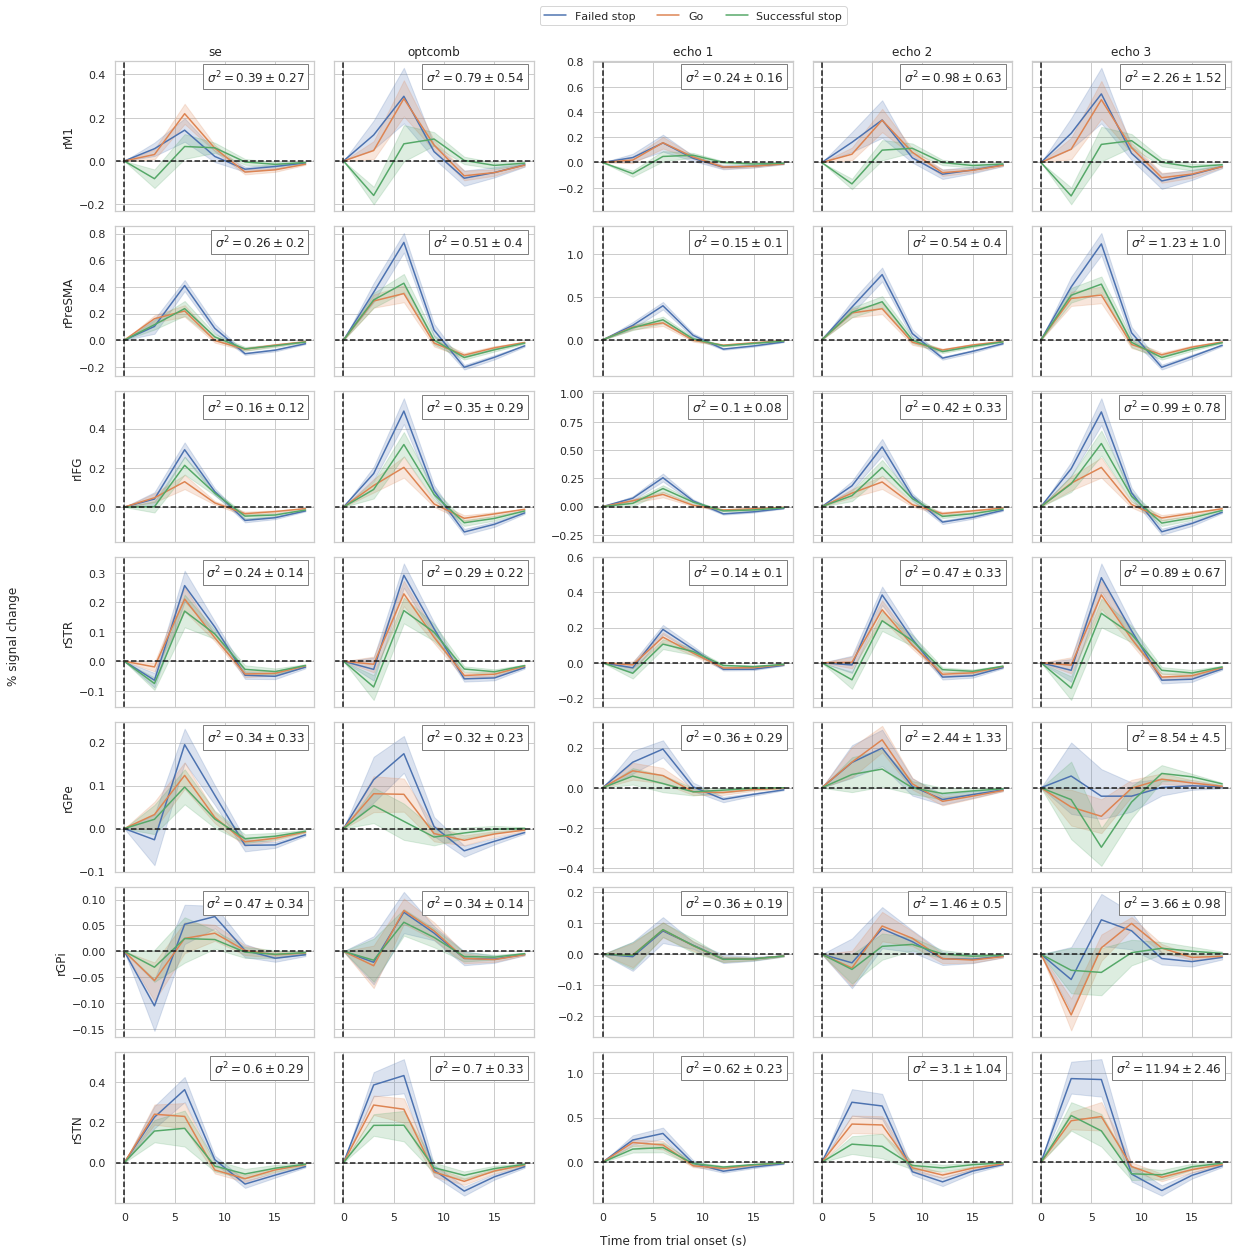

In [19]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

f, ax = make_plot(plot_dict=rfGroupsCwD['psc'],
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='psc', 
                  oversample=1,
                  plot_type='first_level',
                  add_sigma2=True,
                  sharey=[(0, 1), (2, 3, 4)])

### Estimate ROI-wise T2*

In [45]:
ses_ts_raw = [get_session_timeseries('echo_1', standardize=False, drop_label=False), 
              get_session_timeseries('echo_2', standardize=False, drop_label=False), 
              get_session_timeseries('echo_3', standardize=False, drop_label=False)]
ses_ts_raw = pd.concat(ses_ts_raw, axis=0)
ses_ts_raw = ses_ts_raw.reset_index().melt(id_vars=['subject', 'session', 'run', 'time'], 
                                           var_name='roi', value_name='signal')

In [77]:
import numpy as np

def fit_monoexp_decay(x, tes=[9.66, 24.87, 40.08]):
#     print(x)
    # dep var y, log-space
    log_signal = np.log(x['signal'].values).reshape(3,1)
    
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, -np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, log_signal)
    
    # back to normal space
    beta = fit[0]
    s0 = np.exp(beta[0])
    t2star = 1/beta[1]
    return pd.Series({'s0': s0, 't2*': t2star})
    
t2s = ses_ts_raw.groupby(['subject', 'run', 'roi', 'time']).apply(lambda x: fit_monoexp_decay(x))

In [96]:
def mean_f(x):
    return pd.Series({'s0': np.mean(x['s0']),
                      't2*': np.mean(x['t2*'])})

In [109]:
t2s_roiwise = t2s.reset_index().drop(columns='time').groupby(['subject', 'run', 'roi']).apply(mean_f)
t2s_roiwise = t2s_roiwise.reset_index().groupby(['subject', 'roi']).apply(mean_f)

In [110]:
t2s_roiwise = t2s_roiwise.reset_index()
t2s_roiwise['s0'] = t2s_roiwise['s0'].apply(lambda x: x[0])
t2s_roiwise['t2*'] = t2s_roiwise['t2*'].apply(lambda x: x[0])

In [122]:
t2s_roiwise.groupby('roi')['s0', 't2*'].mean()

# s0 is remarkably high for STN? Something with the application of the mask/extracting timeseries after all? 
# Although T2* is fine...

,s0,t2*
roi,,
ACC,3554.234960,33.782000
M1,4004.397884,31.617831
THA,2348.129961,27.072756
lGPe,2171.351682,12.117491
lGPi,3025.497683,17.654340
lM1,1026.514082,43.020484
lPreSMA,1960.527685,34.405198
lSTN,8772.001767,15.397410
lSTR,2527.381612,22.497721


In [125]:
## Ok, we have the T2*-estimates per ROI
## Now we can fit linear functions of t-value ~ TE

In [306]:
def fit_linear(x, tes=[9.66, 24.87, 40.08]):
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, x['t'])[0]
    return pd.Series({'intercept': fit[0], 'slope': fit[1]})
    
lin_model = t_vals_long.loc[np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])].groupby(['subject', 'Event', 'ROI']).apply(lambda x: fit_linear(x))

In [307]:
def fit_lin2(x):
    y = x['slope'].values[:,np.newaxis]
    intercept = np.ones_like(y)
    X = np.hstack([intercept, x['t2*'].values[:,np.newaxis]])
    
    fit = np.linalg.lstsq(X, y)[0]
    return pd.Series({'intercept_0': fit[0], 'slope_2': fit[1]})

t2s_slope_df_level2 = t2s_slope_df.groupby(['subject']).apply(fit_lin2)
t2s_slope_df_level2['intercept_0'] = t2s_slope_df_level2['intercept_0'].apply(lambda x: x[0])
t2s_slope_df_level2['slope_2'] = t2s_slope_df_level2['slope_2'].apply(lambda x: x[0])

Ttest_1sampResult(statistic=4.369135655827815, pvalue=0.0004768583243785713)

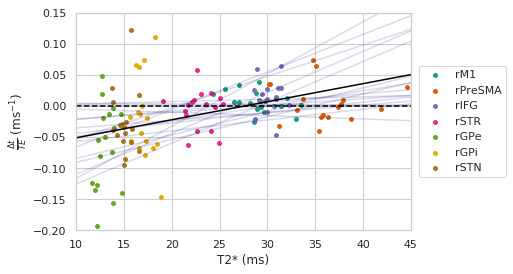

In [330]:
from matplotlib import colors
f, ax = plt.subplots(1, 1)
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_slope_df.ROI.unique().shape[0])

# points per ROI, so we can color
for i, ROI in enumerate(plot_masks):
    t2s_this_roi = t2s_slope_df.loc[t2s_slope_df.ROI==ROI]
    ax.scatter(t2s_this_roi['t2*'], t2s_this_roi['slope'], color=plt.get_cmap('Dark2')(norm(i)), label=ROI, s=15)

# add individual regression lines
for sub in range(t2s_slope_df_level2.shape[0]):
    int_, beta = t2s_slope_df_level2.iloc[sub]
    ax.plot(xs, int_+beta*xs, alpha=0.15, color='navy')

# mean reg line
int_overall, slope_overall = t2s_slope_df_level2.mean()
ax.plot(xs, int_overall+slope_overall*xs, color='black')
ax.axhline(0, color='black', linestyle='--')

# labels, legend
ax.set_xlabel('T2* (ms)')
ax.set_ylabel('$\\frac{\Delta{t}}{TE}$ (ms$^{-1}$)')
ax.set_ylim([-0.2, 0.15])
ax.set_xlim([10, 45])
ax.legend(loc=5, bbox_to_anchor=[1.3, 0.5])

# test for slope effect
stats.ttest_1samp(t2s_slope_df_level2['slope_2'], popmean=0)

In [309]:
def fit_poly2(x):
    y = x['slope'].values[:,np.newaxis]
    intercept = np.ones_like(y)
    x1 = x['t2*'].values[:,np.newaxis]
    X = np.hstack([intercept, x1, x1**2])    
    
    fit = np.linalg.lstsq(X, y)[0]
    return pd.Series({'intercept_0': fit[0], 'beta_1': fit[1], 'beta_2': fit[2]})

t2s_slope_df_poly2 = t2s_slope_df.groupby(['subject']).apply(fit_poly2)
t2s_slope_df_poly2['intercept_0'] = t2s_slope_df_poly2['intercept_0'].apply(lambda x: x[0])
t2s_slope_df_poly2['beta_1'] = t2s_slope_df_poly2['beta_1'].apply(lambda x: x[0])
t2s_slope_df_poly2['beta_2'] = t2s_slope_df_poly2['beta_2'].apply(lambda x: x[0])
# t2s_slope_df_poly2

0.002905726415898058

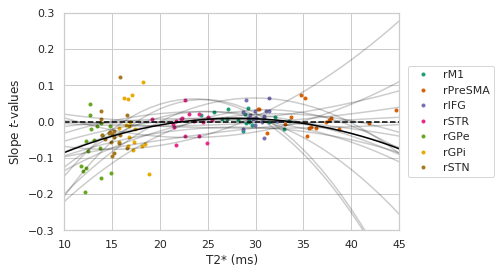

In [313]:
from matplotlib import colors
f, ax = plt.subplots(1,1)
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_slope_df.ROI.unique().shape[0])

# points per ROI, so we can color
for i, ROI in enumerate(plot_masks):
    t2s_this_roi = t2s_slope_df.loc[t2s_slope_df.ROI==ROI]
    ax.plot(t2s_this_roi['t2*'], t2s_this_roi['slope'], '.', color=plt.get_cmap('Dark2')(norm(i)), label=ROI)

# add individual regression lines
for sub in range(t2s_slope_df_poly2.shape[0]):
    int_, beta1, beta2 = t2s_slope_df_poly2.iloc[sub]
    ax.plot(xs, int_ + beta1*xs + beta2*xs**2, alpha=0.2, color='black')

# mean reg line
int_overall, beta1, beta2 = t2s_slope_df_poly2.mean()
ax.plot(xs, int_overall+beta1*xs+beta2*xs**2, color='black')
ax.axhline(0, color='black', linestyle='--')

# labels, legend
ax.set_xlabel('T2* (ms)')
ax.set_ylabel('Slope $t$-values')
ax.set_ylim([-0.2, 0.15])
ax.set_xlim([10, 45])
ax.legend(loc=5, bbox_to_anchor=[1.3, 0.5])

ax.set_ylim([-0.3, .3])

# test for slope effect
slope_overall

### Extract $t$-values from GLMs

In [129]:
def get_t_vals(rfGroup, data_type='se', contrast_type='first_level'):
    contrasts = {}
    if contrast_type == 'first_level':
        if data_type == 'se':
            contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
            contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
            contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        else:
            contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
            contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
            contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    else:
        if data_type == 'se':
            contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  0, 0, 1, 0]
            contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, -1, 0, 1, 0]
            contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  1, 0, 0, 0]
        else:
            contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,  0, 0]
            contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, -1, 0]
            contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,  1, 0]

    pes = []
    var_pes = []
    ts = []
    for c_name, c_vector in contrasts.items():
        pe = rfGroup._get_response_fitters().apply(lambda x: estimate_cope(x, c_vector))
        var_pe = rfGroup._get_response_fitters().apply(lambda x: estimate_varcope(x, c_vector))
        t = pe / np.sqrt(var_pe)
        
        pe['Event'] = c_name
        var_pe['Event'] = c_name
        t['Event'] = c_name
        
        pes.append(pe)
        var_pes.append(var_pe)
        ts.append(t)

    return pd.concat(pes), pd.concat(var_pes), pd.concat(ts)
    
def estimate_varcope(response_fitter, C):
    X = response_fitter.X
    sigma2 = np.std(response_fitter._residuals)**2  #sigma2
    
    varcope = sigma2*np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
    return varcope

def estimate_cope(response_fitter, C):
    X = response_fitter.X
    Y = response_fitter.input_signal
##    C * (X'*X)^{-1} * (X'*Y)
    XtXinv = np.linalg.pinv(np.dot(X.T, X))
    XY = np.dot(X.T, Y)
    copes = np.dot(C, np.dot(XtXinv, XY))
    return pd.Series(copes, index=response_fitter.input_signal.columns)

In [130]:
# get first-level t-values
pe_se, var_se, t_se = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se')
pe_oc, var_oc, t_oc = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc')

t_se['Data'] = 'Single echo'
t_oc['Data'] = 'Multi echo (OC)'

pe_se['Data'] = 'Single echo'
pe_oc['Data'] = 'Multi echo (OC)'

# also per echo
pe_e1, var_e1, t_e1 = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1')
pe_e2, var_e2, t_e2 = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2')
pe_e3, var_e3, t_e3 = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3')
pe_e1['Data'] = 'Echo 1'
pe_e2['Data'] = 'Echo 2'
pe_e3['Data'] = 'Echo 3'
t_e1['Data'] = 'Echo 1'
t_e2['Data'] = 'Echo 2'
t_e3['Data'] = 'Echo 3'

# Add contrasts
pe_se_contrast, var_se_contrast, t_se_contrast = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se', contrast_type='contrast')
pe_oc_contrast, var_oc_contrast, t_oc_contrast = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc', contrast_type='contrast')

t_se_contrast['Data'] = 'Single echo'
t_oc_contrast['Data'] = 'Multi echo (OC)'

pe_se_contrast['Data'] = 'Single echo'
pe_oc_contrast['Data'] = 'Multi echo (OC)'

# also per echo
pe_e1_contrast, var_e1_contrast, t_e1_contrast = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1', contrast_type='contrast')
pe_e2_contrast, var_e2_contrast, t_e2_contrast = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2', contrast_type='contrast')
pe_e3_contrast, var_e3_contrast, t_e3_contrast = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3', contrast_type='contrast')
pe_e1_contrast['Data'] = 'Echo 1'
pe_e2_contrast['Data'] = 'Echo 2'
pe_e3_contrast['Data'] = 'Echo 3'
t_e1_contrast['Data'] = 'Echo 1'
t_e2_contrast['Data'] = 'Echo 2'
t_e3_contrast['Data'] = 'Echo 3'

pes = pd.concat([pe_se, pe_oc, pe_e1, pe_e2, pe_e3, pe_se_contrast, pe_oc_contrast, pe_e1_contrast, pe_e2_contrast, pe_e3_contrast])
t_vals = pd.concat([t_se, t_oc, t_e1, t_e2, t_e3, t_se_contrast, t_oc_contrast, t_e1_contrast, t_e2_contrast, t_e3_contrast])

pes_long = pes.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='pe')
t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t')

### Make barplots
1. betas ~ roi * sequence, t-test for difference between events
2. t ~ sequence * roi, t-test for difference between protocols

In [140]:
def get_protocol_differences(x, dv='t'):
    se_oc = x.loc[x['Data'] == 'Single echo', dv].values - x.loc[x['Data'] == 'Multi echo (OC)', dv].values
    
    return pd.Series({'Single echo - Multi echo': se_oc[0]})

def get_protocol_differences_echos(x, dv='t'):
    e1_e2 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 2', dv].values
    e1_e3 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    e2_e3 = x.loc[x['Data'] == 'Echo 2', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    
    return pd.Series({'Echo 1 - Echo 2': e1_e2[0],
                      'Echo 1 - Echo 3': e1_e3[0],
                      'Echo 2 - Echo 3': e2_e3[0]
                      })

# pe_differences = pes_long.groupby(['Data', 'subject', 'ROI']).apply(get_contrast_differences, dv='pe').reset_index()
t_differences = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences, dv='t').reset_index()
t_differences_echo = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences_echos, dv='t').reset_index()

# Only test right-lateralized ROIs
# pe_differences = pe_differences.loc[np.in1d(pe_differences.ROI, plot_masks)]
t_differences = t_differences.loc[np.in1d(t_differences.ROI, plot_masks)]
t_differences_echo = t_differences_echo.loc[np.in1d(t_differences_echo.ROI, plot_masks)]

In [141]:
from scipy import stats
from statsmodels.sandbox.stats import multicomp

In [142]:
# Statistics: PE differences
pe_differences_long = pes_long.loc[np.in1d(pes_long['Event'], ['Failed stop - successful stop', 'Failed stop - go', 'Successful stop - go'])] #pe_differences.loc[np.in1d(pe_differences.ROI, plot_masks)]
pe_differences_long['Contrast'] = pe_differences_long['Event']
pe_differences_long['Value'] = pe_differences_long['pe']
p_vals_pe = pe_differences_long.groupby(['Data', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# separate FDR correction for the OC and SE data
p_vals_oc = p_vals_pe['Multi echo (OC)'].reset_index()
p_vals_se = p_vals_pe['Single echo'].reset_index()

# multiple comparisons correction
p_vals_oc['p_corrected'] = multicomp.fdrcorrection0(p_vals_oc['Value'])[1]
p_vals_se['p_corrected'] = multicomp.fdrcorrection0(p_vals_se['Value'])[1]


# Statistics: t-value differences
t_differences_long = t_differences.melt(id_vars=['subject', 'Event', 'ROI'], var_name='Contrast', value_name='Value')
p_vals_t = t_differences_long.groupby(['Event', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# MC correction again
p_vals_t = p_vals_t.reset_index()
p_vals_t['p_corrected'] = multicomp.fdrcorrection0(p_vals_t['Value'])[1]


# Statistics: per echo
t_differences_echo_long = t_differences_echo.melt(id_vars=['subject', 'Event', 'ROI'], var_name='Contrast', value_name='Value')
p_vals_t_echo = t_differences_echo_long.groupby(['Event', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# MC correction
p_vals_t_echo = p_vals_t_echo.reset_index()
p_vals_t_echo['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_echo['Value'])[1]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [143]:
# Any significant differences between sequences?
display(np.any(p_vals_t['p_corrected'] < 0.05))

display(p_vals_t)

False

,Event,ROI,Contrast,Value,p_corrected
0,Failed stop,rGPe,Single echo - Multi echo,0.167560,0.703751
1,Failed stop,rGPi,Single echo - Multi echo,0.826706,0.933491
2,Failed stop,rIFG,Single echo - Multi echo,0.597569,0.933491
3,Failed stop,rM1,Single echo - Multi echo,0.521784,0.933491
4,Failed stop,rPreSMA,Single echo - Multi echo,0.018688,0.261638
5,Failed stop,rSTN,Single echo - Multi echo,0.849220,0.933491
6,Failed stop,rSTR,Single echo - Multi echo,0.564268,0.933491
7,Failed stop - go,rGPe,Single echo - Multi echo,0.716480,0.933491
8,Failed stop - go,rGPi,Single echo - Multi echo,0.504619,0.933491
9,Failed stop - go,rIFG,Single echo - Multi echo,0.287709,0.929522


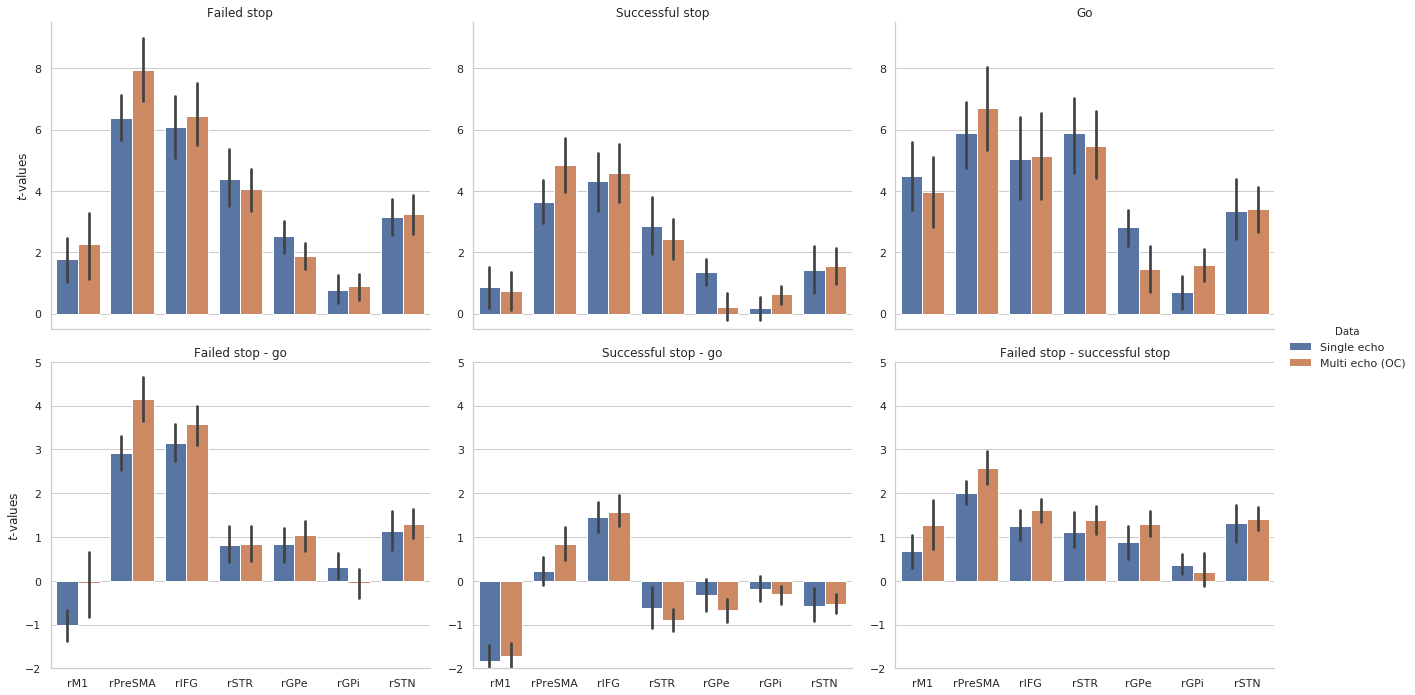

In [144]:
# t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t')

g = sns.catplot(x='ROI', y='t', hue='Data', col='Event', col_wrap=3, 
                order=plot_masks, col_order=['Failed stop', 'Successful stop', 'Go',
                                             'Failed stop - go', 'Successful stop - go', 'Failed stop - successful stop'],
                data=t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
                kind='bar', ci=67, aspect=1.2, sharey=False)

g.set_axis_labels("", "$t$-values").set_titles("{col_name}")
# manually set y-limits
for i in [0,1,2]:
    g.axes[i].set_ylim(-.5, 9.5)
for i in [3,4,5]:
    g.axes[i].set_ylim(-2, 5)

In [332]:
# Epic Figure 5

In [436]:
# load zmaps, thresholds
import pickle as pkl
with open('glm_figure_axes/zmaps.pkl', 'rb') as f:
    zmaps_combined = pkl.load(f)

with open('glm_figure_axes/thresholds.pkl', 'rb') as f:
    thresholds_combined = pkl.load(f)
    
from nilearn import plotting

bg_img = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

In [462]:
from utils import get_roi_dict, add_contours, get_prop_limits
roi_map = get_roi_dict()

In [463]:
from functools import partial

plot_spm = partial(plotting.plot_stat_map, 
                   bg_img=bg_img, display_mode='y', cut_coords=[-13], 
                   colorbar=None, annotate=False, vmax=6)

def add_rois(disp, roi_dict):
    plot_rois = ['rIFG', 'M1',
             'lSTR', 'lGPe', 'lGPi', 'lSTN',
             'rSTR', 'rGPe', 'rGPi', 'rSTN']
    for roi_ in plot_rois:
        roi_map = roi_dict[roi_]
        add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

def fix_lims(disp, display_mode='y'):
    # determine limits (xlim/ylim) based on first column, and apply to all others
    this_key = list([x for x in disp.axes.keys()])[0]
    # Determine new xlim/ylim
    cur_xlim = disp.axes[this_key].ax.get_xlim()
    cur_ylim = disp.axes[this_key].ax.get_ylim()
    if display_mode == 'x':
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0, 1], cur_ylim)
    elif display_mode == 'z' and 'STN' in roi:
        new_xlim = get_prop_limits([.25, .75], cur_xlim)
        new_ylim = get_prop_limits([.40, .90], cur_ylim)
    elif display_mode == 'z' and 'STR' in roi:
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0.3, 1], cur_ylim)
    elif display_mode == 'y':
        new_xlim = get_prop_limits([.26, .74], cur_xlim)
        new_ylim = get_prop_limits([.25, .75], cur_ylim)

    # Change axes limits
    disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
    disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

In [ ]:
f, axes = plt.subplots(3, 3)

gs0 = gridspec.GridSpec(3, 3, figure=f)

location_dict = {'Failed stop': [0, 0],
                 'Go': [1, 1],
                 'Successful stop': [2, 2],
                 
                 'Failed stop - go': [1, 0],
                 'Failed stop - successful stop': [2, 0],
                 'Successful stop - go': [2, 1]}

for contrast, loc in location_dict.items():    
    sns.barplot(x='ROI', y='t', hue='Data', ax=axes[loc[0],loc[1]], order=plot_masks, 
                data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
                                     np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
                ci=67)
    axes[loc[0], loc[1]].set_title(contrast)

for ax_ in axes.ravel():
    ax_.legend().set_visible(False)
    ax_.set_xlabel('')
    ax_.set_ylabel('')

for row in [0,1]:
    for col in [0, 1, 2]:
        axes[row, col].tick_params(axis='x',          # changes apply to the x-axis
                                   which='both',      # both major and minor ticks are affected
                                   bottom=False,      # ticks along the bottom edge are off
                                   top=False,         # ticks along the top edge are off
                                   labelbottom=False) # labels along the bottom edge are off
for col in [0, 1, 2]:
    axes[2, col].tick_params(axis='x', which='both', rotation=90)
# turn off other axes to remove background grid
axes[0, 1].axis('Off')
axes[0, 1].set_title('Failed stop - go')
axes[0, 2].axis('Off')
axes[0, 2].set_title('Failed stop - successful stop')
axes[1, 2].axis('Off')
axes[1, 2].set_title('Successful stop - go')

# plot SPMs
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,1], wspace=0.05)
ax01_0 = plt.Subplot(f, gs01[0])
f.add_subplot(ax01_0)
disp = plot_spm(zmaps_combined[0], threshold=thresholds_combined[0], axes=ax01_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

ax01_1 = plt.Subplot(f, gs01[1])
f.add_subplot(ax01_1)
disp = plot_spm(zmaps_combined[1], threshold=thresholds_combined[1], axes=ax01_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,2], wspace=0.05)
ax1 = plt.Subplot(f, gs02[0])
f.add_subplot(ax1)
# disp = plot_spm(zmaps_combined[2], threshold=thresholds_combined[2], axes=ax1)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)
ax2 = plt.Subplot(f, gs02[1])
f.add_subplot(ax2)
# disp = plot_spm(zmaps_combined[3], threshold=thresholds_combined[3], axes=ax2)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)


gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1,2], wspace=0.05)
ax1 = plt.Subplot(f, gs12[0])
f.add_subplot(ax1)
# disp = plot_spm(zmaps_combined[4], threshold=thresholds_combined[4], axes=ax1)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)
ax2 = plt.Subplot(f, gs12[1])
f.add_subplot(ax2)
# disp = plot_spm(zmaps_combined[5], threshold=thresholds_combined[5], axes=ax2)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)

f.set_size_inches(13, 10)

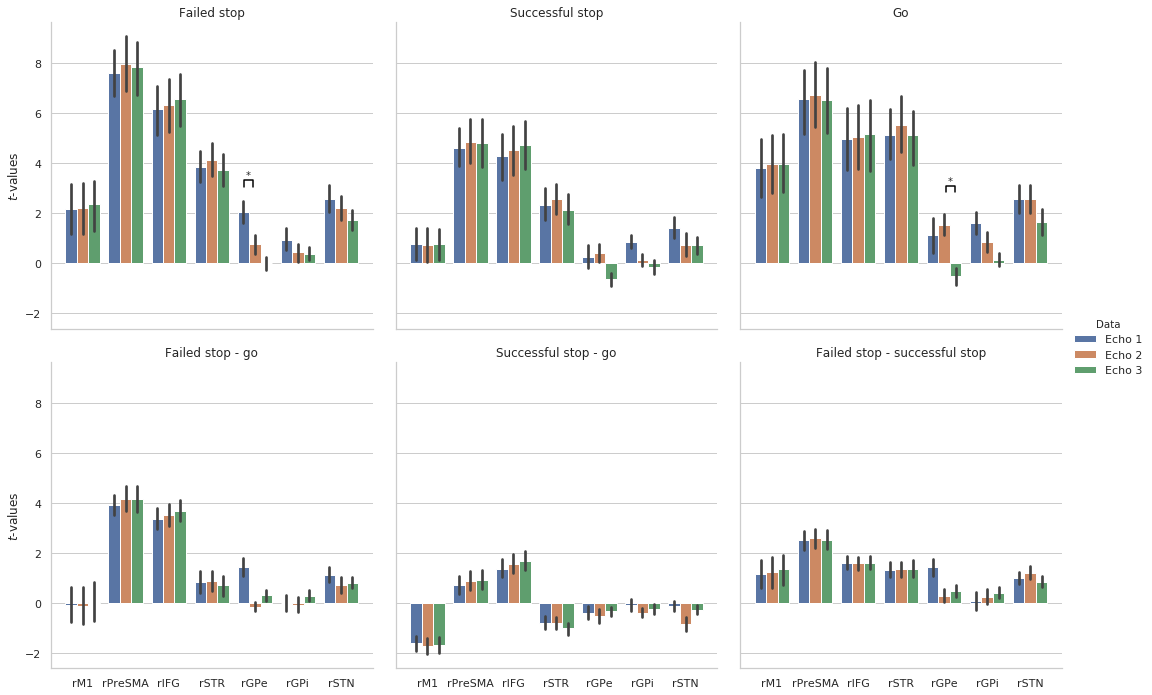

In [145]:
# Per echo
# get significance?
data_to_plot = t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                               np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])]

g = sns.catplot(x='ROI', y='t', hue='Data', col='Event', col_wrap=3, 
                order=plot_masks, col_order=['Failed stop', 'Successful stop', 'Go',
                                             'Failed stop - go', 'Successful stop - go', 'Failed stop - successful stop'],
                data=t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])], 
                kind='bar', ci=67)

g.set_axis_labels("", "$t$-values").set_titles("{col_name}")


mns = data_to_plot.groupby(['Event', 'ROI', 'Data']).t.mean()
ses = data_to_plot.groupby(['Event', 'ROI', 'Data']).t.apply(lambda x: np.std(x)/np.sqrt(len(x)))


# loop over ROIs
for ax_num, event in enumerate(['Failed stop', 'Successful stop', 'Go']):
    for i, ROI in enumerate(plot_masks):
        p_vals_this_roi = p_vals_t_echo.loc[(p_vals_t_echo.Event == event) & (p_vals_t_echo['ROI'] == ROI), 'p_corrected'].values

        n_sign = 0
        if p_vals_this_roi[1] < 0.05:
            barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3, 
                                      ax=g.axes[ax_num], 
                                      barh=0.02)
            n_sign += 1
        if p_vals_this_roi[2] < 0.05:
            barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3,
                                      ax=g.axes[ax_num], barh=0.02)
            n_sign += 1
        if p_vals_this_roi[0] < 0.05:
            barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3,
                                      ax=g.axes[ax_num], dh = 0.15*(n_sign>0), barh=0.02)

In [147]:
from statsmodels.stats.anova import AnovaRM

In [279]:
to_test = t_vals_long
to_test['t'] = np.abs(to_test['t'])
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Go', 'Failed stop', 'Successful stop'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
print(res.summary())
res_table = res.summary().tables[0]

                    Anova
                Num DF  Den DF  F Value Pr > F
----------------------------------------------
Data            1.0000  16.0000  0.0499 0.8260
ROI             6.0000  96.0000 13.8453 0.0000
Event           2.0000  32.0000 15.6368 0.0000
Data:ROI        6.0000  96.0000  2.9983 0.0099
Data:Event      2.0000  32.0000  0.4833 0.6212
ROI:Event      12.0000 192.0000  5.8597 0.0000
Data:ROI:Event 12.0000 192.0000  0.7509 0.7001



In [280]:
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.050,0.826
ROI,6.0,96.0,13.845,0.000
Event,2.0,32.0,15.637,0.000
Data:ROI,6.0,96.0,2.998,0.017
Data:Event,2.0,32.0,0.483,0.817
ROI:Event,12.0,192.0,5.860,0.000
Data:ROI:Event,12.0,192.0,0.751,0.817


In [281]:
anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Failed stop - Go', 'Failed stop - successful stop', 'Successful stop - go'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]

In [282]:
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.054103,0.819020
ROI,6.0,96.0,5.360074,0.000578
Event,1.0,16.0,3.126883,0.168122
Data:ROI,6.0,96.0,2.463465,0.068406
Data:Event,1.0,16.0,1.576663,0.318178
ROI:Event,6.0,96.0,4.516811,0.001573
Data:ROI:Event,6.0,96.0,0.666648,0.789517


In [283]:
# to_test = t_vals_long
# to_test['t'] = np.abs(to_test['t'])
# to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
#                       (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

# for event in to_test.Event.unique():
#     print(event)
#     anova = AnovaRM(data=to_test.loc[(to_test.Event == event) & 
#                                      (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
#                                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
#                     depvar='t', subject='subject', within=['Data', 'ROI'])
#     res = anova.fit()

#     print(res.summary())

In [285]:
to_test = t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                          np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])]
to_test['t'] = np.abs(to_test['t'])
to_test['TE'] = to_test['Data'].replace({'Echo 1': 9.66, 'Echo 2': 24.87, 'Echo 3': 40.08})

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [325]:
anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event,['Go', 'Failed stop', 'Successful stop'])) &
                                 (np.in1d(to_test.Data, ['Echo 1', 'Echo 2', 'Echo 3'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['TE', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(4)

,Num DF,Den DF,F Value,Pr > F
TE,2.0,32.0,4.7892,0.0212
ROI,6.0,96.0,17.9569,0.0000
Event,2.0,32.0,13.6312,0.0001
TE:ROI,12.0,192.0,4.0355,0.0000
TE:Event,4.0,64.0,2.9539,0.0309
ROI:Event,12.0,192.0,5.2943,0.0000
TE:ROI:Event,24.0,384.0,1.2336,0.2080


In [352]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#data = sm.datasets.get_rdataset("dietox", "geepack").data
#tmp = to_test#.loc[(to_test['ROI'] == 'rSTN') & (to_test['Event'] == 'Failed stop')]
tmp = to_test.loc[np.in1d(to_test.Event, ['Failed stop', 'Go', 'Successful stop'])]
md = smf.mixedlm("t ~ TE*ROI", tmp, groups=tmp["subject"])
mdf = md.fit()
#print(mdf.summary())

res_table = mdf.summary().tables[1]
p_vals = pd.to_numeric(res_table.iloc[:-1,-3])
res_table.iloc[:-1,-3] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(4)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,2.295,0.672,3.414,0.00466667,0.977,3.612
ROI[T.rGPi],-0.551,0.601,-0.916,0.42,-1.728,0.627
ROI[T.rIFG],3.021,0.601,5.027,0,1.843,4.199
ROI[T.rM1],0.945,0.601,1.572,0.180444,-0.233,2.123
ROI[T.rPreSMA],4.125,0.601,6.863,0,2.947,5.303
ROI[T.rSTN],0.635,0.601,1.056,0.370364,-0.543,1.813
ROI[T.rSTR],1.825,0.601,3.036,0.007,0.647,3.003
TE,-0.032,0.015,-2.113,0.0816667,-0.062,-0.002
TE:ROI[T.rGPi],0.011,0.022,0.516,0.652615,-0.031,0.054
TE:ROI[T.rIFG],0.046,0.022,2.131,0.0816667,0.004,0.088


In [324]:
res_table = mdf.summary().tables[1]
p_vals = pd.to_numeric(res_table.iloc[:-1,-3])
res_table.iloc[:-1,-3] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(4)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,2.607,0.669,3.897,0,1.296,3.918
ROI[T.rGPi],-0.551,0.577,-0.954,0.388571,-1.681,0.580
ROI[T.rIFG],3.021,0.577,5.237,0,1.890,4.152
ROI[T.rM1],0.945,0.577,1.637,0.148364,-0.186,2.075
ROI[T.rPreSMA],4.125,0.577,7.150,0,2.994,5.255
ROI[T.rSTN],0.635,0.577,1.100,0.333538,-0.496,1.765
ROI[T.rSTR],1.825,0.577,3.163,0.0064,0.694,2.955
Event[T.Go],0.289,0.169,1.714,0.1376,-0.041,0.620
Event[T.Successful stop],-1.226,0.169,-7.267,0,-1.557,-0.895
TE,-0.032,0.015,-2.201,0.064,-0.061,-0.004


In [103]:
# LMER: t-value ~ TE?
t_vals_long.head()

,subject,Data,Event,ROI,t
0,01,Single echo,Successful stop,ACC,0.324595
1,02,Single echo,Successful stop,ACC,5.600088
2,03,Single echo,Successful stop,ACC,8.029704
3,04,Single echo,Successful stop,ACC,2.203587
4,05,Single echo,Successful stop,ACC,6.509952


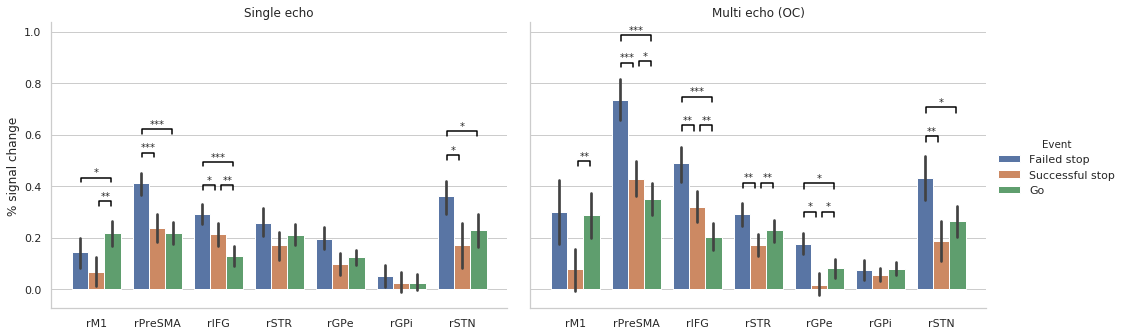

In [137]:
# Parameter estimates
# index ROIs, data types
data_to_plot = pes_long.loc[np.in1d(pes_long.ROI, plot_masks) & np.in1d(pes_long.Data, ['Single echo', 'Multi echo (OC)'])]

g = sns.catplot(x='ROI', y='pe', hue='Event', col='Data', 
                order=plot_masks, hue_order=['Failed stop', 'Successful stop', 'Go'],
                data=data_to_plot, 
                kind='bar', ci=67, aspect=1.4)
g.set_axis_labels("", "% signal change").set_titles("{col_name}")


# def add_statistics(x, from_bar, to_bar, ax, y=0.55, h=0.025, col='k'):
#     if from_bar == 0:
#         x1 = x - 0.33
#     elif from_bar == 1:
#         x1 = x + .1
#     if to_bar == 1:
#         x2 = x - .1
#     elif to_bar == 2:
#         x2 = x + .33
    
#     ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


mns = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.mean()
ses = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.apply(lambda x: np.std(x)/np.sqrt(len(x)))


# loop over ROIs
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_se.loc[(p_vals_se['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], dh = 0.15*(n_sign>0), barh=0.02)

# again, now ME
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_oc.loc[(p_vals_oc['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], dh = 0.15*(n_sign>0), barh=0.02)

### Do the same thing, but now extract beta and t-values from GLMs fit by nistats

In [524]:
from nilearn.image import index_img
def apply_mask(img, mask):
    img_data = img.get_data()
    mask_data = mask.get_data()
    
    # apply binary mask
    mask_binary = mask_data > 0
    mask_trimmed = mask_data[mask_binary]
    img_data_trimmed = img_data[mask_binary]
    
    return np.average(img_data_trimmed, weights=mask_trimmed)

def _get_roi_idx(label, atlas_labels):
    return list(roi_atlas.labels).index(label)

def _get_session_fn(session, sub):
    if session == 'Single echo':
        return "data/deriv/fmriprep/sub-{}/ses-se/model_onset-shift/firstlevel_fwhm-5.pkl".format(str(sub).zfill(2))
    elif session == 'Multi echo (OC)':
        return "data/deriv/fmriprep/sub-{}/ses-me/model_onset-shift/firstlevel_fwhm-5_comb-optcomb.pkl".format(str(sub).zfill(2))
    elif 'Echo' in session:
        return "data/deriv/fmriprep/sub-{}/ses-me/model_onset-shift/firstlevel_fwhm-5_echo-{}.pkl".format(str(sub).zfill(2), session[-1])
    

In [525]:
from itertools import product
subs = [x for x in np.arange(1,19) if not x == 12]
contrasts = ['go_trial', 'failed_stop', 'successful_stop', 
             'failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial']
sessions  = ['Single echo', 'Multi echo (OC)', 'Echo 1', 'Echo 2', 'Echo 3']
rois = list(roi_atlas.labels)

tval_df = pd.DataFrame(list(product(subs, sessions, rois, contrasts)), columns=['subject', 'Data', 'ROI', 'Event'])
tval_df['beta-value'] = np.nan
tval_df['variance'] = np.nan
tval_df['t-value'] = np.nan
# tval_df['p-value'] = np.nan  # pointless, we need the second-level p-value

In [526]:
# loop over subjects,s essions, contrasts to fill DataFrame
for sub in np.arange(1,19):
    print('\nSub {} '.format(sub), end='')
    if sub == 12:
        continue
    
    # single echo first
    for session in sessions:
        print('session {} '.format(session), end='')
        with open(_get_session_fn(session, sub), 'rb') as f:
            model = pkl.load(f)
    
        for contrast in contrasts:
#            print('contrast {} '.format(contrast), end='')
            nii_beta = model.compute_contrast(contrast, output_type='effect_size')
            nii_var = model.compute_contrast(contrast, output_type='effect_variance')
            nii_t = model.compute_contrast(contrast, output_type='stat')
#             nii_p = model.compute_contrast(contrast, output_type='p_value')
            
            for roi in rois:
                mean_beta = apply_mask(nii_beta, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))
                mean_var = apply_mask(nii_var, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))
                mean_t = apply_mask(nii_t, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))
#                 mean_p = apply_mask(nii_p, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))

                tval_df.loc[(tval_df['subject'] == sub) & \
                            (tval_df['Data'] == session) & \
                            (tval_df['ROI'] == roi) & \
                            (tval_df['Event'] == contrast), 'beta-value'] = mean_beta
                tval_df.loc[(tval_df['subject'] == sub) & \
                            (tval_df['Data'] == session) & \
                            (tval_df['ROI'] == roi) & \
                            (tval_df['Event'] == contrast), 'variance'] = mean_var
                tval_df.loc[(tval_df['subject'] == sub) & \
                            (tval_df['Data'] == session) & \
                            (tval_df['ROI'] == roi) & \
                            (tval_df['Event'] == contrast), 't-value'] = mean_t
#                 tval_df.loc[(tval_df['subject'] == sub) & \
#                             (tval_df['session'] == session) & \
#                             (tval_df['roi'] == roi) & \
#                             (tval_df['contrast'] == contrast), 'p-value'] = mean_p


Sub 1 session Single echo 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


session Multi echo (OC) session Echo 1 

FileNotFoundError: [Errno 2] No such file or directory: 'data/deriv/fmriprep/sub-01/ses-me/model_onset-shift/firstlevel_fwhm-5_echo-1.pkl'

In [ ]:
tval_df['Event'] = tval_df['Event'].replace({'go_trial': 'Go', 'successful_stop': 'Successful stop', 'failed_stop': 'Failed stop'})
tval_df = tval_df.loc[np.in1d(tval_df['Event'], ['Go', 'Successful stop', 'Failed stop'])]

In [ ]:
def get_contrast_differences(x, dv='pe'):
#    print(x)
    fs_ss = x.loc[x['Event'] == 'Failed stop', dv].values - x.loc[x['Event'] == 'Successful stop', dv].values
    fs_go = x.loc[x['Event'] == 'Failed stop', dv].values - x.loc[x['Event'] == 'Go', dv].values
    ss_go = x.loc[x['Event'] == 'Successful stop', dv].values - x.loc[x['Event'] == 'Go', dv].values
    return pd.Series({'Failed stop - Successful stop': fs_ss[0],
                      'Failed stop - Go': fs_go[0],
                      'Successful stop - Go': ss_go[0]})

def get_protocol_differences(x, dv='t'):
    se_oc = x.loc[x['Data'] == 'Single echo', dv].values - x.loc[x['Data'] == 'Multi echo (OC)', dv].values
    
    return pd.Series({'Single echo - Multi echo': se_oc[0]})

def get_protocol_differences_echos(x, dv='t'):
    e1_e2 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 2', dv].values
    e1_e3 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    e2_e3 = x.loc[x['Data'] == 'Echo 2', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    
    return pd.Series({'Echo 1 - Echo 2': e1_e2[0],
                      'Echo 1 - Echo 3': e1_e3[0],
                      'Echo 2 - Echo 3': e2_e3[0]
                      })

In [ ]:
tval_df_echos = tval_df.loc[np.in1d(tval_df['Data'], ['Echo 1', 'Echo 2', 'Echo 3'])]
tval_df_seme = tval_df.loc[np.in1d(tval_df['Data'], ['Single echo', 'Multi echo (OC)'])]

pe_differences = tval_df_seme.groupby(['Data', 'subject', 'ROI']).apply(get_contrast_differences, dv='beta-value').reset_index()


In [ ]:
tval_df_echos = tval_df.loc[np.in1d(tval_df['Data'], ['Echo 1', 'Echo 2', 'Echo 3'])]
tval_df_seme = tval_df.loc[np.in1d(tval_df['Data'], ['Single echo', 'Multi echo (OC)'])]

pe_differences = tval_df_seme.groupby(['Data', 'subject', 'ROI']).apply(get_contrast_differences, dv='beta-value').reset_index()
t_differences = tval_df_seme.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences, dv='t-value').reset_index()
t_differences_echo = tval_df_echos.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences_echos, dv='t-value').reset_index()

# Only test right-lateralized ROIs
pe_differences = pe_differences.loc[np.in1d(pe_differences.ROI, plot_masks)]
t_differences = t_differences.loc[np.in1d(t_differences.ROI, plot_masks)]
t_differences_echo = t_differences_echo.loc[np.in1d(t_differences_echo.ROI, plot_masks)]

In [ ]:
# Statistics: PE differences
pe_differences_long = pe_differences.melt(id_vars=['subject', 'Data', 'ROI'], var_name='Contrast', value_name='Value')
p_vals_pe = pe_differences_long.groupby(['Data', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# separate FDR correction for the OC and SE data
p_vals_oc = p_vals['Multi echo (OC)'].reset_index()
p_vals_se = p_vals['Single echo'].reset_index()

# multiple comparisons correction
p_vals_oc['p_corrected'] = multicomp.fdrcorrection0(p_vals_oc['Value'])[1]
p_vals_se['p_corrected'] = multicomp.fdrcorrection0(p_vals_se['Value'])[1]


# Statistics: t-value differences
t_differences_long = t_differences.melt(id_vars=['subject', 'Event', 'ROI'], var_name='Contrast', value_name='Value')
p_vals_t = t_differences_long.groupby(['Event', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# MC correction again
p_vals_t = p_vals_t.reset_index()
p_vals_t['p_corrected'] = multicomp.fdrcorrection0(p_vals_t['Value'])[1]


# Statistics: per echo
t_differences_echo_long = t_differences_echo.melt(id_vars=['subject', 'Event', 'ROI'], var_name='Contrast', value_name='Value')
p_vals_t_echo = t_differences_echo_long.groupby(['Event', 'ROI', 'Contrast'])['Value'].apply(lambda x: stats.ttest_1samp(x, popmean=0)[1])

# MC correction
p_vals_t_echo = p_vals_t_echo.reset_index()
p_vals_t_echo['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_echo['Value'])[1]

In [ ]:
# Any significant differences between sequences?
np.any(p_vals_t['p_corrected'] < 0.05)

p_vals_t

In [ ]:
# t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t-value')
tval_df

g = sns.catplot(x='ROI', y='t-value', hue='Data', col='Event', col_wrap=3, 
                order=plot_masks, col_order=['Failed stop', 'Successful stop', 'Go'],
                data=tval_df.loc[np.in1d(tval_df.ROI, plot_masks) & 
                                 np.in1d(tval_df.Data, ['Single echo', 'Multi echo (OC)'])], 
                kind='bar', ci=67)

g.set_axis_labels("", "$t$-values").set_titles("{col_name}")

In [ ]:
# Per echo
# get significance?
t_vals_long = tval_df
data_to_plot = t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])]

g = sns.catplot(x='ROI', y='t-value', hue='Data', col='Event', col_wrap=3, 
                order=plot_masks, col_order=['Failed stop', 'Successful stop', 'Go'],
                data=t_vals_long.loc[np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Echo 1', 'Echo 2', 'Echo 3'])], 
                kind='bar', ci=67)

g.set_axis_labels("", "$t$-values").set_titles("{col_name}")


mns = data_to_plot.groupby(['Event', 'ROI', 'Data'])['t-value'].mean()
ses = data_to_plot.groupby(['Event', 'ROI', 'Data'])['t-value'].apply(lambda x: np.std(x)/np.sqrt(len(x)))


# loop over ROIs
for ax_num, event in enumerate(['Failed stop', 'Successful stop', 'Go']):
    for i, ROI in enumerate(plot_masks):
        p_vals_this_roi = p_vals_t_echo.loc[(p_vals_t_echo.Event == event) & (p_vals_t_echo['ROI'] == ROI), 'p_corrected'].values

        n_sign = 0
        if p_vals_this_roi[1] < 0.05:
            barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3, 
                                      ax=g.axes[ax_num], 
                                      barh=0.02)
            n_sign += 1
        if p_vals_this_roi[2] < 0.05:
            barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3,
                                      ax=g.axes[ax_num], barh=0.02)
            n_sign += 1
        if p_vals_this_roi[0] < 0.05:
            barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                      [mns[(event, ROI)].max()] * 3, 
                                      yerr=[ses[(event, ROI)].values.max()] * 3,
                                      ax=g.axes[ax_num], dh = 0.15*(n_sign>0), barh=0.02)

In [ ]:
# Parameter estimates
# index ROIs, data types
data_to_plot = tval_df.loc[np.in1d(tval_df.ROI, plot_masks) & np.in1d(tval_df.Data, ['Single echo', 'Multi echo (OC)'])]

g = sns.catplot(x='ROI', y='beta-value', hue='Event', col='Data', 
                order=plot_masks, hue_order=['Failed stop', 'Successful stop', 'Go'],
                data=data_to_plot, 
                kind='bar', ci=67, aspect=1.4)
g.set_axis_labels("", "% signal change").set_titles("{col_name}")


# def add_statistics(x, from_bar, to_bar, ax, y=0.55, h=0.025, col='k'):
#     if from_bar == 0:
#         x1 = x - 0.33
#     elif from_bar == 1:
#         x1 = x + .1
#     if to_bar == 1:
#         x2 = x - .1
#     elif to_bar == 2:
#         x2 = x + .33
    
#     ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


mns = data_to_plot.groupby(['Data', 'ROI', 'Event'])['beta-value'].mean()
ses = data_to_plot.groupby(['Data', 'ROI', 'Event'])['beta-value'].apply(lambda x: np.std(x)/np.sqrt(len(x)))


# loop over ROIs
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_se.loc[(p_vals_se['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], dh = 0.15*(n_sign>0), barh=0.02)

# again, now ME
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_oc.loc[(p_vals_oc['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], dh = 0.15*(n_sign>0), barh=0.02)

In [170]:
def get_pars(x, par='failed_stop'):
    out = x.betas.loc[[(par, 'intercept', 'canonical_hrf')]].reset_index(drop=True).T[0]
    return out

def extract_betas(rfGroup):
    successful_stop = rfGroup._get_response_fitters().apply(get_pars, par='successful_stop')
    failed_stop = rfGroup._get_response_fitters().apply(get_pars, par='failed_stop')
    go = rfGroup._get_response_fitters().apply(get_pars, par='go_trial')

    successful_stop['event_type'] = 'successful_stop'
    failed_stop['event_type'] = 'failed_stop'
    go['event_type'] = 'go_trial'

    betas = pd.concat([successful_stop, failed_stop, go]).reset_index()
    return betas

def extract_t(rfGroup):
    rfGroup._get_response_fitters()

betas_se = extract_betas(rfGroupsCwD['psc']['se'])
betas_oc = extract_betas(rfGroupsCwD['psc']['optcomb'])
betas_se['data_type'] = 'se'
betas_oc['data_type'] = 'oc'

betas = pd.concat([betas_se, betas_oc])

In [426]:
# sns.barplot(x='variable', y='value', hue='event_type', hue_order=['failed_stop', 'go_trial', 'successful_stop'],
#             data=betas_se[['subject', 'event_type', 'rM1', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']].melt(id_vars=['subject', 'event_type']), ci=67)
# plt.gcf().set_size_inches(15,5)

In [427]:
# sns.barplot(x='variable', y='value', hue='event_type', hue_order=['failed_stop', 'go_trial', 'successful_stop'],
#             data=betas_oc[['subject', 'event_type', 'rM1', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']].melt(id_vars=['subject', 'event_type']), ci=67)
# plt.gcf().set_size_inches(15,5)

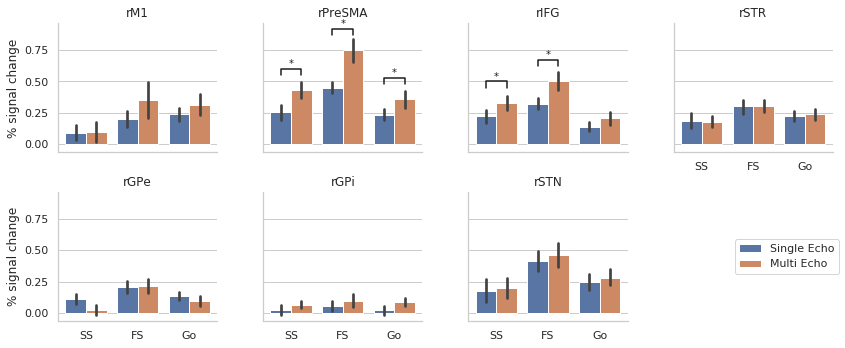

In [444]:
betas_m = betas.melt(id_vars=['subject', 'event_type', 'data_type'], var_name='ROI', value_name='Beta')
betas_m['Trial type'] = betas_m['event_type'].replace({'successful_stop': 'Successful stop', 'failed_stop': 'Failed stop', 'go_trial': 'Go'})
betas_m['Data'] = betas_m['data_type'].replace({'se': 'Single Echo', 'oc': 'Multi Echo'})

plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

g = sns.catplot(x='Trial type', y='Beta', hue='Data', col='ROI', ci=67, kind='bar', 
                col_order=plot_masks, col_wrap=4, sharey='row',
                data=betas_m.loc[np.in1d(betas_m.ROI, plot_masks)],
                aspect=.8, height=3, legend=False)

# for ax in g.axes.flat:
#     box = ax.get_position()
#     ax.set_position([box.x0,box.y0,box.width*0.9,box.height])

plt.legend(loc='center', bbox_to_anchor=(2,0.5))
#ax.axes[0].annotate('test', (0, .2))

g.set_axis_labels("", "% signal change").set_xticklabels(["SS", "FS", "Go"]).set_titles("{col_name}")
#ax.axes[1].


# statistical annotation

# rPreSMA: all three trial types
x1, x2 = -.2, .2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .55, .05, 'k'
g.axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
g.axes[1].text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = .8, 1.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .87, .05, 'k'
g.axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
g.axes[1].text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = 1.8, 2.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .48, .05, 'k'
g.axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
g.axes[1].text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


# rIFG: failed stop and successful stop
x1, x2 = -.2, .2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .45, .05, 'k'
g.axes[2].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
g.axes[2].text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = .8, 1.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = .62, .05, 'k'
g.axes[2].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
g.axes[2].text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

plt.gcf().set_size_inches(12,5)

In [428]:
def two_sample_t_test(x, out_type='t'):
    del x['event_type']
    del x['subject']
    a1 = x.loc[x.data_type=='se']
    a2 = x.loc[x.data_type=='oc']
    del a1['data_type']
    del a2['data_type']
    dif = a1-a2
    if out_type == 't':
        return pd.Series(stats.ttest_1samp(dif, 0)[0], index=a1.columns)
    else:
        return pd.Series(stats.ttest_1samp(dif, 0)[1], index=a1.columns)

In [313]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [330]:
??multipletests

In [342]:
betas2 = betas_[['subject', 'event_type', 'data_type'] + plot_masks]
del betas2['THA']

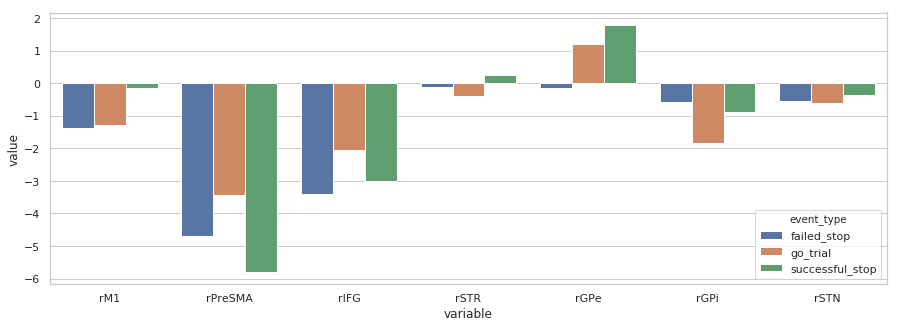

In [343]:
t1 = betas2.groupby(['event_type']).apply(lambda x: two_sample_t_test(x)).reset_index().melt(id_vars=['event_type'])
ps = betas2.groupby(['event_type']).apply(lambda x: two_sample_t_test(x, out_type='p')).reset_index().melt(id_vars=['event_type'])
sns.barplot(x='variable', hue='event_type', y='value', data=t1)
plt.gcf().set_size_inches(15,5)

In [344]:
multipletests(ps['value'], method='fdr_bh')

(array([False, False, False,  True,  True,  True,  True, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([4.41598880e-01, 4.63892439e-01, 9.17619644e-01, 2.48915634e-03,
        1.88046756e-02, 5.72888282e-04, 1.88046756e-02, 2.02099500e-01,
        3.61700279e-02, 9.17619644e-01, 8.81625784e-01, 9.17619644e-01,
        9.17619644e-01, 4.73086361e-01, 2.43355330e-01, 8.30763140e-01,
        2.43355330e-01, 6.75446369e-01, 8.30763140e-01, 8.30763140e-01,
        8.81625784e-01]),
 0.002439557259668823,
 0.002380952380952381)

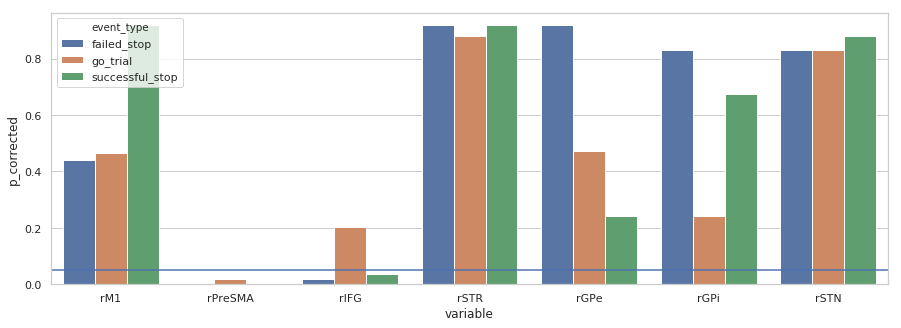

In [345]:
ps['p_corrected'] = multipletests(ps['value'], method='fdr_bh')[1]
sns.barplot(x='variable', hue='event_type', y='p_corrected', data=ps)
plt.gcf().set_size_inches(15,5)
plt.axhline(0.05)

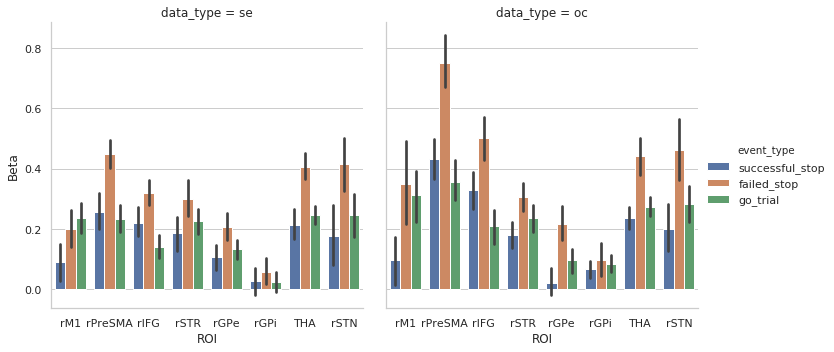

In [338]:
betas_m = betas.melt(id_vars=['subject', 'event_type', 'data_type'], var_name='ROI', value_name='Beta')
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'THA', 'rSTN']

sns.catplot(x='ROI', y='Beta', hue='event_type', col='data_type', ci=67, kind='bar', 
            order=plot_masks, sharey=True,
            data=betas_m.loc[np.in1d(betas_m.ROI, plot_masks)])

In [184]:
from scipy import stats

In [261]:
def do_t_test(x):
    t_vals = stats.ttest_1samp(x, popmean=0)[0]
    return pd.Series(t_vals, index=x.columns)

In [265]:
betas_ = betas
betas_['subject'] = pd.to_numeric(betas['subject'], errors='coerce')
t_vals = betas_.groupby(['data_type', 'event_type']).apply(do_t_test)

In [266]:
t_vals

subject       ACC        M1       THA      lGPe  \
data_type event_type                                                          
oc        failed_stop      7.056221  6.034261  2.142105  7.159219  3.622370   
          go_trial         7.056221  4.151390  2.805559  8.159639  4.314922   
          successful_stop  7.056221  4.232793  0.930831  6.288223  2.955060   
se        failed_stop      7.056221  7.564738  3.474399  8.509815  6.700885   
          go_trial         7.056221  4.488003  4.453552  7.732752  4.678534   
          successful_stop  7.056221  3.499096  1.161550  4.262645  3.544507   

                               lGPi       lM1   lPreSMA      lSTN      lSTR  \
data_type event_type                                                          
oc        failed_stop      3.183907  0.907299  5.598893  4.466150  5.895712   
          go_trial         5.304316  0.751746  3.306859  4.469386  5.426125   
          successful_stop  2.074075  0.214643  3.092845  2.266030  4.567005   
se        failed_stop      0.828238  3.672648  4.631606  5.373582  4.876969   
          go_trial         0.365034  2.516691  2.746251  3.804486  5.077428   
          successful_stop -0.036854  0.121640  2.594228  1.899819  3.231603   

                               rGPe      rGPi      rIFG       rM1   rPreSMA  \
data_type event_type                                                          
oc        failed_stop      3.775793  1.702998  6.462521  2.328389  8.210893   
          go_trial         2.219346  2.738883  3.711490  3.461982  5.098119   
          successful_stop  0.489754  2.293023  5.096881  1.152853  6.021449   
se        failed_stop      4.157407  1.274755  6.941437  3.016454  9.105290   
          go_trial         3.792406  0.638986  3.583557  4.633660  4.975137   
          successful_stop  2.354352  0.566704  4.376792  1.432290  4.220220   

                               rSTN      rSTR  
data_type event_type                           
oc        failed_stop      4.580394  6.202362  
          go_trial         4.117675  5.174607  
          successful_stop  2.441237  3.835562  
se        failed_stop      4.694512  4.978897  
          go_trial         3.457728  4.998596  
          successful_stop  1.743423  3.073915

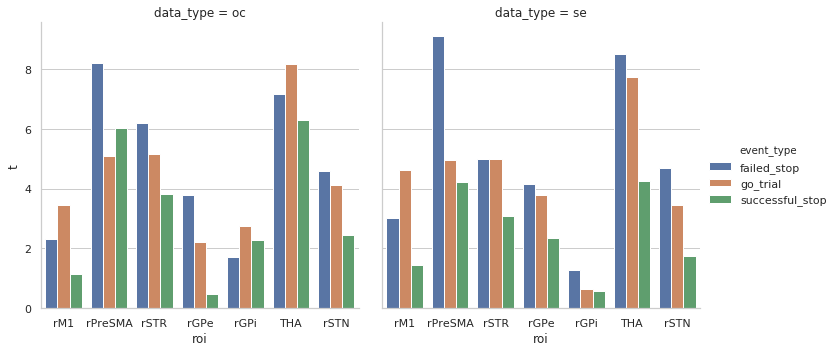

In [274]:
sns.catplot(x='roi', y='t', hue='event_type', col='data_type', kind='bar',
            data=t_vals[plot_masks].reset_index().melt(['data_type', 'event_type'], var_name='roi', value_name='t'))

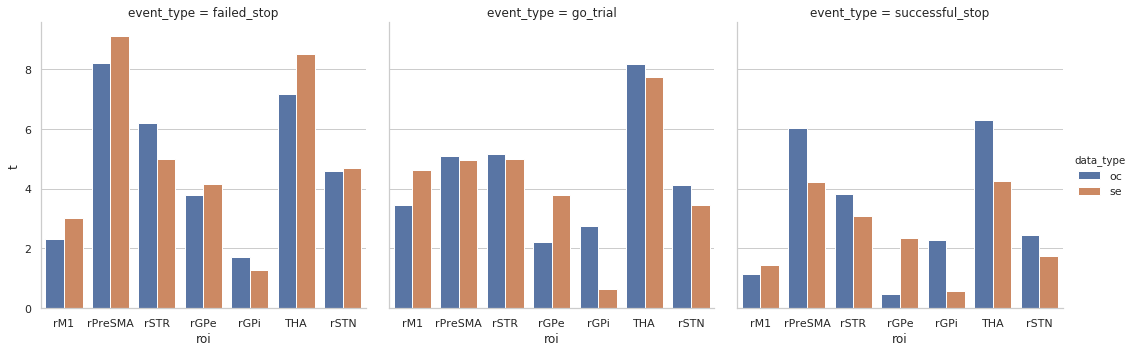

In [275]:
sns.catplot(x='roi', y='t', 
            hue='data_type', col='event_type', kind='bar',
            data=t_vals[plot_masks].reset_index().melt(['data_type', 'event_type'], 
                                                       var_name='roi', value_name='t'))

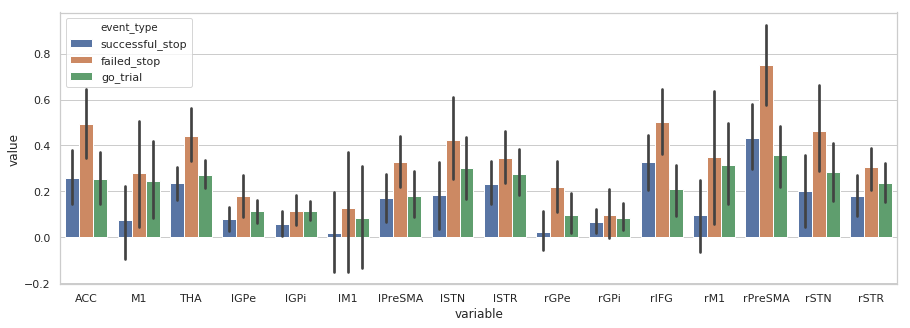

In [155]:
pars_m = pars_me.melt(id_vars=['subject', 'event_type'])
sns.barplot(x='variable', y='value', hue='event_type', data=pars_m)
plt.gcf().set_size_inches(15,5)

In [122]:
rfGroupsCwD['psc']['se']._get_response_fitters().iloc[0].betas.loc[[('go_trial', 'intercept', 'canonical_hrf'),
                                                                    ('successful_stop', 'intercept', 'canonical_hrf'),
                                                                    ('failed_stop', 'intercept', 'canonical_hrf')]].reset_index(level=[1,2], drop=True).T#.T

event type,go_trial,successful_stop,failed_stop
ACC,0.186778,0.008525,0.197610
M1,0.251650,-0.119286,0.050031
THA,0.323753,0.133388,0.451848
lGPe,0.155146,0.024916,0.221328
lGPi,0.182484,-0.050367,0.077404
lM1,0.278456,-0.106631,0.223854
lPreSMA,0.125640,0.039663,0.121329
lSTN,0.402226,0.024719,0.296352
lSTR,0.191016,0.025275,0.115526
rGPe,0.213855,-0.146374,0.306331


In [70]:
rfGroupsCwD['psc']['se']._get_response_fitters().apply(lambda x: x.betas.loc[[('go_trial', 'intercept', 'canonical_hrf'),
                                                                    ('successful_stop', 'intercept', 'canonical_hrf'),
                                                                    ('failed_stop', 'intercept', 'canonical_hrf')]].reset_index(drop=True).melt())[0]

,variable,value
0,ACC,0.186778
1,ACC,0.008525
2,ACC,0.197610
3,M1,0.251650
4,M1,-0.119286
5,M1,0.050031
6,THA,0.323753
7,THA,0.133388
8,THA,0.451848
9,lGPe,0.155146


In [49]:
tmp = rfGroupsCwD['psc']['se']._get_response_fitters().apply(lambda x: x.betas.reset_index().melt(id_vars=['event type', 'regressor']))
# tmp[0]

,event type,regressor,variable,value
0,confounds,intercept,covariate,intercept
1,go_trial,canonical_hrf,covariate,intercept
2,go_trial,canonical_hrf_time_derivative,covariate,intercept
3,successful_stop,canonical_hrf,covariate,intercept
4,successful_stop,canonical_hrf_time_derivative,covariate,intercept
5,failed_stop,canonical_hrf,covariate,intercept
6,failed_stop,canonical_hrf_time_derivative,covariate,intercept
7,confounds,intercept,ACC,-0.0549874
8,go_trial,canonical_hrf,ACC,0.186778
9,go_trial,canonical_hrf_time_derivative,ACC,-0.0188517


lSTN..rSTN..rSTR..rIFG..

(<Figure size 576x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc120034588>,
       dtype=object))

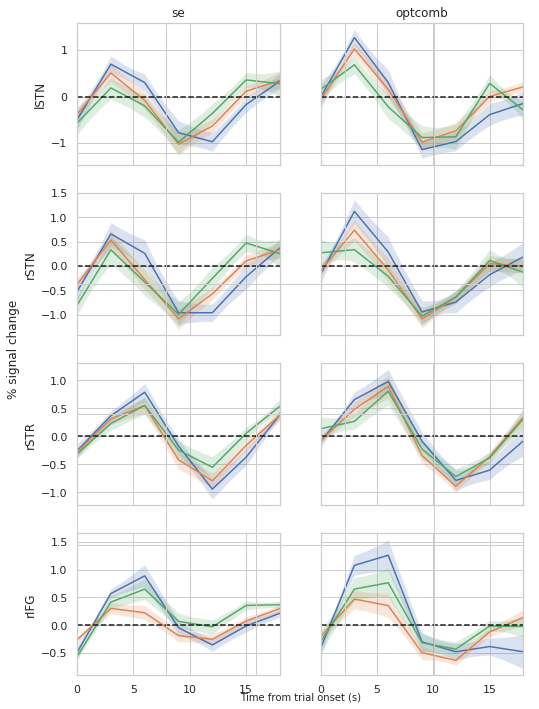

In [15]:
# zoom in on rSTN, lSTN, STR, rIFG
%matplotlib inline
columns = ['se', 'optcomb']

make_plot(plot_dict=rfGroups['psc'],
          y_label='% signal change',
          columns=columns, 
          masks=['lSTN', 'rSTN', 'rSTR', 'rIFG'], 
          data_type='psc', 
          oversample=4,
          plot_type='first_level')

### Sanity check: What does M1 do (left & right) with responses?

In [16]:
rfGroups_motor_response = {'zscore': {}, 'psc': {}}
evs = ('response_left', 'response_right')

for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    for standardization in rfGroups_motor_response.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = get_session_timeseries(ses, standardize=standardization)
        onsets = get_all_onsets(ses=ses, event_types=evs)
        onsets['onset'] -= 1.5
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., 
                                               oversample_design_matrix=100, event=evs, concatenate_runs=False)
        rfGroup.add_event(interval=[0,18], n_regressors=7)
        rfGroup.fit(concatenate_runs=False, type='ar(1)')

        rfGroups_motor_response[standardization][ses] = rfGroup

rfGroups_motor_response

Data: se...zscore...

psc...

Data: optcomb...zscore...

psc...

Data: echo_1...zscore...

psc...

Data: echo_2...zscore...

psc...

Data: echo_3...zscore...

psc...

{'zscore': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7fc1213baba8>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11b9c4518>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11b38b588>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11adab828>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11a7161d0>},
 'psc': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11be000b8>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11b6d8630>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11b09f160>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11aa5d748>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7fc11a4070f0>}}

## Plot 3:
$t$-values of motor areas timecourses after motor response

rPreSMA.....lM1.....rM1.....rIFG.....

(<Figure size 1440x864 with 21 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9d9227da0>,
       dtype=object))

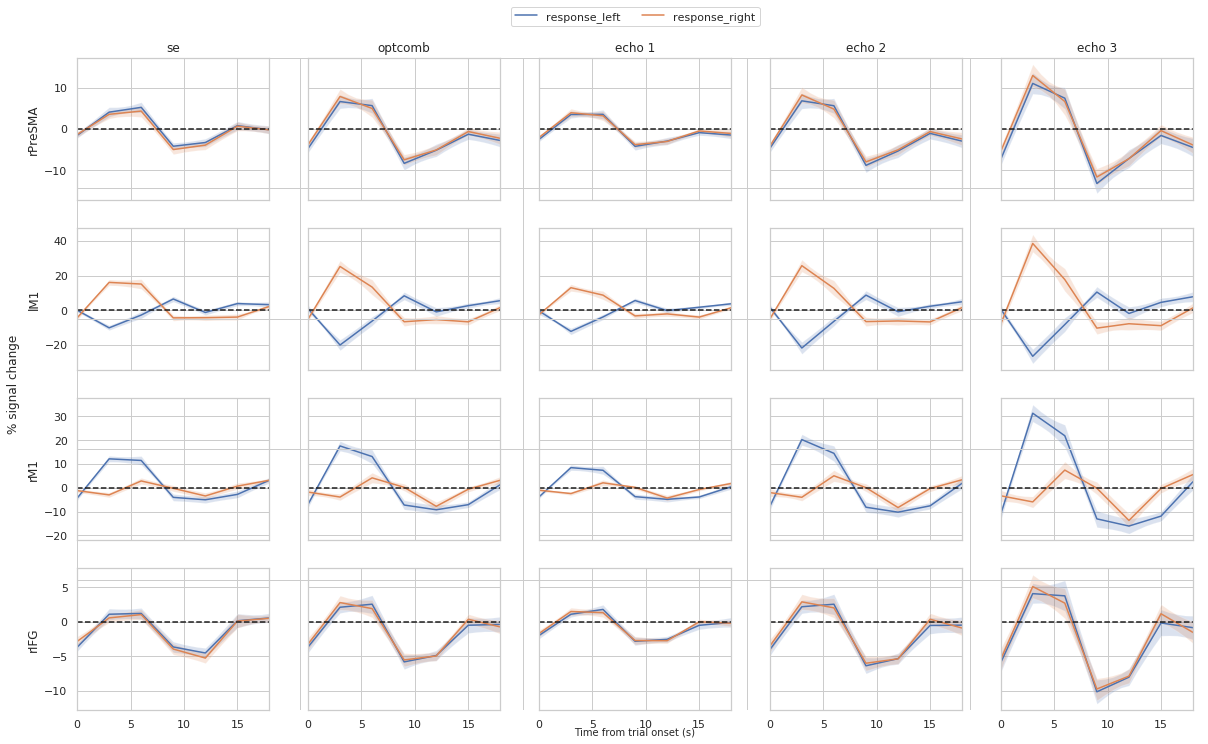

In [83]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)

columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
masks_motor = ['rPreSMA', 'lM1', 'rM1', 'rIFG']
# make_plot(rfGroups_motor_response['psc'], 
#           y_label='t values',
#           columns=columns, 
#           masks=masks_motor, 
#           data_type='t', 
#           oversample=4)

make_plot(rfGroups_motor_response['psc'], 
          y_label='% signal change',
          columns=columns, 
          masks=masks_motor, 
          data_type='psc', 
          oversample=4,
          plot_type='first_level',
          event_types=evs)

### Canonical HRF with time derivative

In [442]:
rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.iloc[0].betas

ACC        M1  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.017629 -0.069139   
go_trial        intercept canonical_hrf                  0.032634  0.309684   
                          canonical_hrf_time_derivative -0.215635 -0.118824   
failed_stop     intercept canonical_hrf                 -0.043204  0.041527   
                          canonical_hrf_time_derivative  0.080893  0.180224   
successful_stop intercept canonical_hrf                 -0.240150 -0.188183   
                          canonical_hrf_time_derivative -0.047776  0.057290   

                                                              THA      lGPe  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.052472 -0.033458   
go_trial        intercept canonical_hrf                  0.175912  0.146923   
                          canonical_hrf_time_derivative -0.078682  0.017056   
failed_stop     intercept canonical_hrf                  0.186361 -0.179492   
                          canonical_hrf_time_derivative  0.142898  0.402622   
successful_stop intercept canonical_hrf                  0.043197 -0.057607   
                          canonical_hrf_time_derivative -0.024637  0.025103   

                                                             lGPi       lM1  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.022111 -0.065288   
go_trial        intercept canonical_hrf                  0.084390  0.330436   
                          canonical_hrf_time_derivative -0.033276 -0.445867   
failed_stop     intercept canonical_hrf                  0.163803  0.729318   
                          canonical_hrf_time_derivative -0.487887 -0.042456   
successful_stop intercept canonical_hrf                  0.008136 -0.473878   
                          canonical_hrf_time_derivative -0.070628 -0.100562   

                                                          lPreSMA      lSTN  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.000387 -0.106300   
go_trial        intercept canonical_hrf                  0.086408  0.320758   
                          canonical_hrf_time_derivative -0.115584  0.288259   
failed_stop     intercept canonical_hrf                 -0.028308 -0.030406   
                          canonical_hrf_time_derivative  0.163621  0.633557   
successful_stop intercept canonical_hrf                 -0.336070 -0.011969   
                          canonical_hrf_time_derivative  0.079487  0.088024   

                                                             lSTR      rGPe  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.007444 -0.047404   
go_trial        intercept canonical_hrf                  0.043019  0.206481   
                          canonical_hrf_time_derivative -0.041870 -0.248611   
failed_stop     intercept canonical_hrf                 -0.065438  0.140417   
                          canonical_hrf_time_derivative  0.045082 -0.360026   
successful_stop intercept canonical_hrf                 -0.202588  0.078147   
                          canonical_hrf_time_derivative -0.351155  0.113407   

                                                             rGPi      rIFG  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.054223 -0.061831   
go_trial        intercept canonical_hrf                 -0.127247  0.168816   
                          canonical_hrf_time_derivative -0.052555  0.027189   
failed_stop     intercept canonical_hrf                 -0.029977  0.411413   
                          ca

In [ ]:
betas_me = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
betas_se = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
betas_e1 = rfGroups_canonicalHRF_with_d['psc']['echo_1'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
betas_e2 = rfGroups_canonicalHRF_with_d['psc']['echo_2'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
betas_e3 = rfGroups_canonicalHRF_with_d['psc']['echo_3'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()

sigma2s = pd.concat([sigma2_me, sigma2_se, sigma2_e1, sigma2_e2, sigma2_e3]).reset_index().melt(id_vars=['subject', 'session'])
sns.barplot(x='variable', y='value', hue='session', data=sigma2s.loc[np.in1d(sigma2s.session, ['se', 'optcomb'])])  #!='echo_3']) #sigma2s['variable'], sigma2s['value'], hue=sigma2s['session'])
plt.gcf().set_size_inches(15, 5)

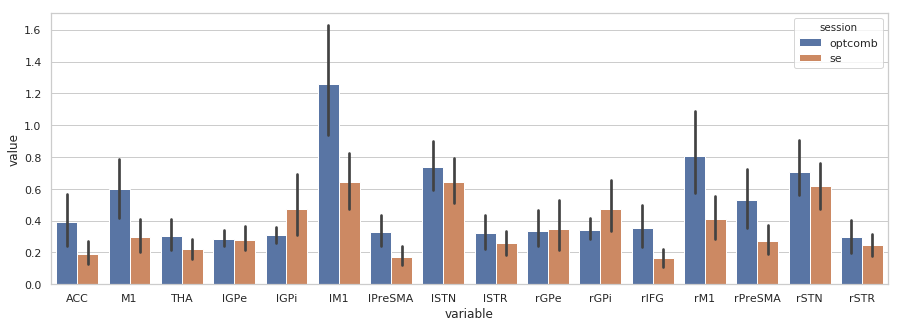

In [440]:
sigma2_me = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_se = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e1 = rfGroups_canonicalHRF_with_d['psc']['echo_1'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e2 = rfGroups_canonicalHRF_with_d['psc']['echo_2'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e3 = rfGroups_canonicalHRF_with_d['psc']['echo_3'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()

sigma2s = pd.concat([sigma2_me, sigma2_se, sigma2_e1, sigma2_e2, sigma2_e3]).reset_index().melt(id_vars=['subject', 'session'])
sns.barplot(x='variable', y='value', hue='session', data=sigma2s.loc[np.in1d(sigma2s.session, ['se', 'optcomb'])])  #!='echo_3']) #sigma2s['variable'], sigma2s['value'], hue=sigma2s['session'])
plt.gcf().set_size_inches(15, 5)

## Calculate mean t-value for failed stop
Get contrast, varCOPE

In [424]:
failed_stop_c_se = np.array([0, 0, 0, 0, 0, 1, 0])
failed_stop_c_me = np.array([0, 0, 0, 1, 0, 0, 0])



In [423]:
rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.iloc[10].X

event type confounds      go_trial                                \
covariate  intercept     intercept                                 
regressor  intercept canonical_hrf canonical_hrf_time_derivative   
0.0              1.0      0.000000                  1.642843e-07   
3.0              1.0      0.467901                  5.159427e-01   
6.0              1.0      1.000000                  1.642843e-07   
9.0              1.0      0.581372                  2.727311e-01   
12.0             1.0      0.725514                 -6.376146e-02   
15.0             1.0     -0.062384                 -2.264938e-01   
18.0             1.0     -0.332928                 -4.948646e-02   
21.0             1.0     -0.175855                  1.671787e-02   
24.0             1.0     -0.058442                  1.427500e-02   
27.0             1.0      0.000000                  1.642843e-07   
30.0             1.0      0.467901                  5.159427e-01   
33.0             1.0      1.000000                  0.000000e+00   
36.0             1.0      0.113471                 -2.432115e-01   
39.0             1.0      0.193415                  4.521812e-01   
42.0             1.0      0.824145                  1.671804e-02   
45.0             1.0      0.522930                  2.870061e-01   
48.0             1.0      0.725514                 -6.376146e-02   
51.0             1.0     -0.062384                 -2.264938e-01   
54.0             1.0     -0.332928                 -4.948646e-02   
57.0             1.0     -0.175855                  1.671787e-02   
60.0             1.0     -0.058442                  1.427500e-02   
63.0             1.0      0.000000                  1.642843e-07   
66.0             1.0      0.467901                  5.159427e-01   
69.0             1.0      1.000000                  1.642843e-07   
72.0             1.0      0.581372                  2.727311e-01   
75.0             1.0      0.725514                 -6.376146e-02   
78.0             1.0     -0.062384                 -2.264936e-01   
81.0             1.0      0.134973                  4.664563e-01   
84.0             1.0      0.824145                  1.671787e-02   
87.0             1.0      0.055029                 -2.289366e-01   
...              ...           ...                           ...   
939.0            1.0      1.000000                  0.000000e+00   
942.0            1.0      0.113471                 -2.432116e-01   
945.0            1.0     -0.274486                 -6.376146e-02   
948.0            1.0     -0.175855                  1.671787e-02   
951.0            1.0     -0.058442                  1.427500e-02   
954.0            1.0      0.000000                  0.000000e+00   
957.0            1.0      0.000000                  0.000000e+00   
960.0            1.0      0.000000                  0.000000e+00   
963.0            1.0      0.000000                  1.642843e-07   
966.0            1.0      0.467901                  5.159427e-01   
969.0            1.0      1.000000                  0.000000e+00   
972.0            1.0      0.113471                 -2.432116e-01   
975.0            1.0     -0.274486                 -6.376146e-02   
978.0            1.0     -0.175855                  1.671787e-02   
981.0            1.0     -0.058442                  1.427517e-02   
984.0            1.0      0.467901                  5.159427e-01   
987.0            1.0      1.000000                  0.000000e+00   
990.0            1.0      0.113471                 -2.432115e-01   
993.0            1.0      0.193415                  4.521812e-01   
996.0            1.0      0.824145                  1.671787e-02   
999.0            1.0      0.055029                 -2.289365e-01   
1002.0           1.0      0.193415                  4.521812e-01   
1005.0           1.0      0.824145                  1.671787e-02   
1008.0           1.0      0.055029                 -2.289365e-01   
1011.0           1.0      0.193415                  4.52

In [412]:
rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.iloc[0].betas

ACC        M1  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.017629 -0.069139   
go_trial        intercept canonical_hrf                  0.032634  0.309684   
                          canonical_hrf_time_derivative -0.215635 -0.118824   
failed_stop     intercept canonical_hrf                 -0.043204  0.041527   
                          canonical_hrf_time_derivative  0.080893  0.180224   
successful_stop intercept canonical_hrf                 -0.240150 -0.188183   
                          canonical_hrf_time_derivative -0.047776  0.057290   

                                                              THA      lGPe  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.052472 -0.033458   
go_trial        intercept canonical_hrf                  0.175912  0.146923   
                          canonical_hrf_time_derivative -0.078682  0.017056   
failed_stop     intercept canonical_hrf                  0.186361 -0.179492   
                          canonical_hrf_time_derivative  0.142898  0.402622   
successful_stop intercept canonical_hrf                  0.043197 -0.057607   
                          canonical_hrf_time_derivative -0.024637  0.025103   

                                                             lGPi       lM1  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.022111 -0.065288   
go_trial        intercept canonical_hrf                  0.084390  0.330436   
                          canonical_hrf_time_derivative -0.033276 -0.445867   
failed_stop     intercept canonical_hrf                  0.163803  0.729318   
                          canonical_hrf_time_derivative -0.487887 -0.042456   
successful_stop intercept canonical_hrf                  0.008136 -0.473878   
                          canonical_hrf_time_derivative -0.070628 -0.100562   

                                                          lPreSMA      lSTN  \
event type      covariate regressor                                           
confounds       intercept intercept                     -0.000387 -0.106300   
go_trial        intercept canonical_hrf                  0.086408  0.320758   
                          canonical_hrf_time_derivative -0.115584  0.288259   
failed_stop     intercept canonical_hrf                 -0.028308 -0.030406   
                          canonical_hrf_time_derivative  0.163621  0.633557   
successful_stop intercept canonical_hrf                 -0.336070 -0.011969   
                          canonical_hrf_time_derivative  0.079487  0.088024   

                                                             lSTR      rGPe  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.007444 -0.047404   
go_trial        intercept canonical_hrf                  0.043019  0.206481   
                          canonical_hrf_time_derivative -0.041870 -0.248611   
failed_stop     intercept canonical_hrf                 -0.065438  0.140417   
                          canonical_hrf_time_derivative  0.045082 -0.360026   
successful_stop intercept canonical_hrf                 -0.202588  0.078147   
                          canonical_hrf_time_derivative -0.351155  0.113407   

                                                             rGPi      rIFG  \
event type      covariate regressor                                           
confounds       intercept intercept                      0.054223 -0.061831   
go_trial        intercept canonical_hrf                 -0.127247  0.168816   
                          canonical_hrf_time_derivative -0.052555  0.027189   
failed_stop     intercept canonical_hrf                 -0.029977  0.411413   
                          ca

In [ ]:
sigma2_me = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_se = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e1 = rfGroups_canonicalHRF_with_d['psc']['echo_1'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e2 = rfGroups_canonicalHRF_with_d['psc']['echo_2'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()
sigma2_e3 = rfGroups_canonicalHRF_with_d['psc']['echo_3'].response_fitters.apply(lambda x: np.std(x._residuals)**2).groupby(level=[0,1]).mean()


In [318]:
failed_go = np.array([0, -1, 0, 1, 0, 0, 0])

In [370]:
response_fitter = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.iloc[0]

In [376]:
X = response_fitter.X.values
Y = response_fitter.input_signal
#    C * (X'*X)^{-1} * (X'*Y)
XtXinv = np.linalg.pinv(np.dot(X.T, X))
XY = np.dot(X.T, Y)
betas = np.dot(C_se, np.dot(XtXinv, XY))


In [377]:
betas

array([ 0.01223203, -0.2802527 ,  0.18325761,  0.19967019,  0.02604307,
       -0.02641129, -0.07718481, -0.02794847, -0.18638796,  0.18948092,
        0.02796285,  0.07473876, -0.39370296,  0.04074314,  0.1332328 ,
       -0.19879634])

In [428]:
def estimate_varcope(response_fitter, C):
    X = response_fitter.X
    sigma2 = np.std(response_fitter._residuals)**2  #sigma2
    
    varcope = sigma2*np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
    return varcope

def estimate_cope(response_fitter, C):
    X = response_fitter.X
    Y = response_fitter.input_signal
#    C * (X'*X)^{-1} * (X'*Y)
    XtXinv = np.linalg.pinv(np.dot(X.T, X))
    XY = np.dot(X.T, Y)
    copes = np.dot(C_se, np.dot(XtXinv, XY))
    return pd.Series(copes, index=response_fitter.input_signal.columns)

C_se = [0, -1, 0, 0, 0, 1, 0]
C_me = [0, -1, 0, 1, 0, 0, 0]

se_varcopes = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.apply(lambda x: estimate_varcope(x, C_se)).groupby(level=[0,1]).mean()
oc_varcopes = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.apply(lambda x: estimate_varcope(x, C_me)).groupby(level=[0,1]).mean()
e1_varcopes = rfGroups_canonicalHRF_with_d['psc']['echo_1'].response_fitters.apply(lambda x: estimate_varcope(x, C_me)).groupby(level=[0,1]).mean()
e2_varcopes = rfGroups_canonicalHRF_with_d['psc']['echo_2'].response_fitters.apply(lambda x: estimate_varcope(x, C_me)).groupby(level=[0,1]).mean()
e3_varcopes = rfGroups_canonicalHRF_with_d['psc']['echo_3'].response_fitters.apply(lambda x: estimate_varcope(x, C_me)).groupby(level=[0,1]).mean()

se_copes = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.apply(lambda x: estimate_cope(x, C_se)).groupby(level=[0,1]).mean()
oc_copes = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.apply(lambda x: estimate_cope(x, C_me)).groupby(level=[0,1]).mean()
e1_copes = rfGroups_canonicalHRF_with_d['psc']['echo_1'].response_fitters.apply(lambda x: estimate_cope(x, C_me)).groupby(level=[0,1]).mean()
e2_copes = rfGroups_canonicalHRF_with_d['psc']['echo_2'].response_fitters.apply(lambda x: estimate_cope(x, C_me)).groupby(level=[0,1]).mean()
e3_copes = rfGroups_canonicalHRF_with_d['psc']['echo_3'].response_fitters.apply(lambda x: estimate_cope(x, C_me)).groupby(level=[0,1]).mean()

#se_copes = 

In [437]:
C_se

[0, -1, 0, 0, 0, 1, 0]

In [431]:
se_t = se_copes/np.sqrt(se_varcopes)
oc_t = oc_copes/np.sqrt(oc_varcopes)

e1_t = e1_copes/np.sqrt(e1_varcopes)
e2_t = e2_copes/np.sqrt(e2_varcopes)
e3_t = e3_copes/np.sqrt(e3_varcopes)

In [429]:
# se_copes / np.sqrt(se_varcopes)
# rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.iloc[0].betas.T

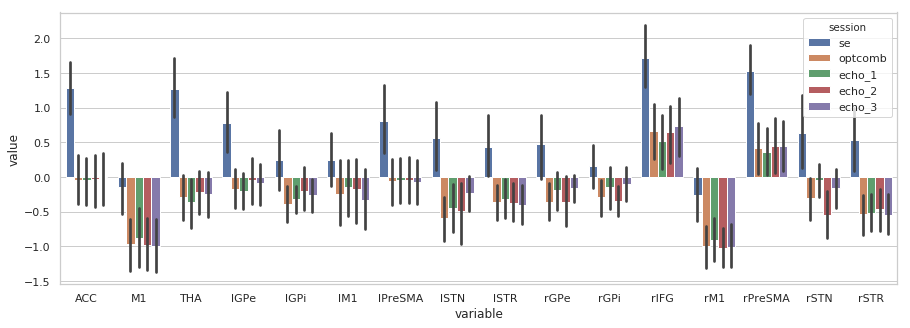

In [436]:
ts = pd.concat([se_t, oc_t, e1_t, e2_t, e3_t]).reset_index().melt(id_vars=['subject', 'session'])

sns.barplot(x='variable', y='value', hue='session', data=ts) #copes['value'], hue=varcopes['session'])
plt.gcf().set_size_inches(15, 5)

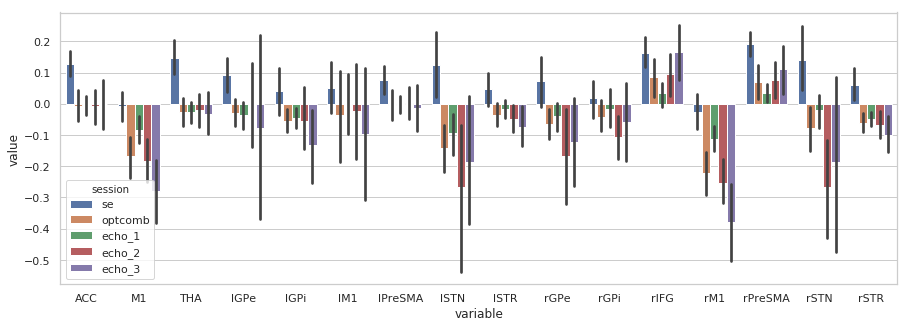

In [434]:
copes = pd.concat([se_copes, oc_copes, e1_copes, e2_copes, e3_copes]).reset_index().melt(id_vars=['subject', 'session'])

sns.barplot(x='variable', y='value', hue='session', data=copes) #copes['value'], hue=varcopes['session'])
plt.gcf().set_size_inches(15, 5)

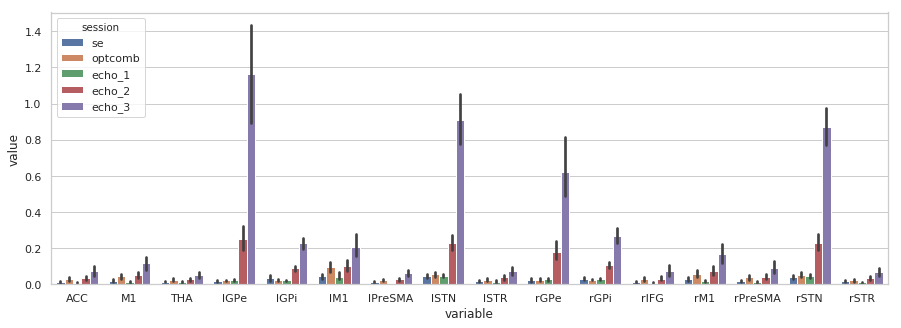

In [432]:
varcopes = pd.concat([se_varcopes, oc_varcopes, e1_varcopes, e2_varcopes, e3_varcopes]).reset_index().melt(id_vars=['subject', 'session'])

sns.barplot(varcopes['variable'], varcopes['value'], hue=varcopes['session'])
plt.gcf().set_size_inches(15, 5)

In [344]:
# OK, so expected varcopes are also mostly higher for the OC data

In [334]:
X = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.iloc[0].X
sigma2 = rfGroups_canonicalHRF_with_d['psc']['se'].response_fitters.iloc[0].sigma2

varcopes1 = sigma2*np.dot(np.dot(failed_go, np.linalg.pinv(np.dot(X.T, X))), failed_go)

In [335]:
X = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.iloc[0].X
sigma2 = rfGroups_canonicalHRF_with_d['psc']['optcomb'].response_fitters.iloc[0].sigma2

varcopes2 = sigma2*np.dot(np.dot(failed_go, np.linalg.pinv(np.dot(X.T, X))), failed_go)

In [131]:
def remove_hemisph(x):
    if x[0] == 'r' or x[0] == 'l':
        return x[1:]
    else:
        return x


rsqs['variable2'] = rsqs['variable'].apply(lambda x: remove_hemisph(x))
rsqs = rsqs.groupby(['subject', 'session', 'variable2']).mean().reset_index()

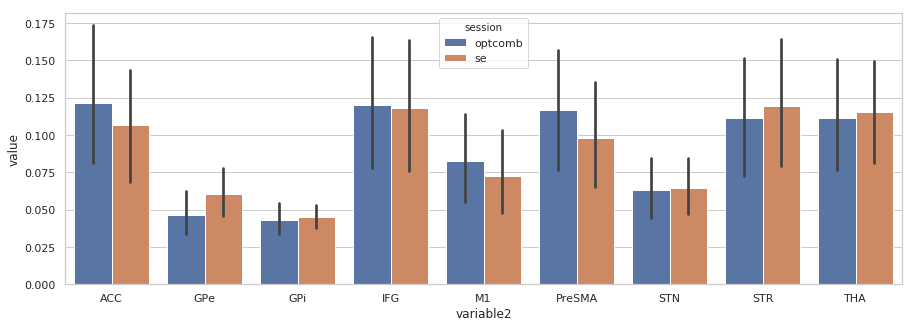

In [133]:
# rsqs = pd.concat([s_0_me, s_0_se]).reset_index().melt(id_vars=['subject', 'session'])
sns.barplot(rsqs['variable2'], rsqs['value'], hue=rsqs['session'])
plt.gcf().set_size_inches(15, 5)

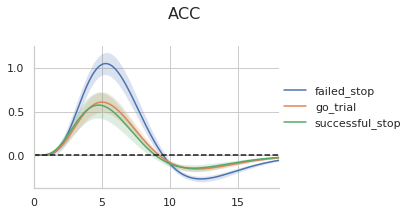

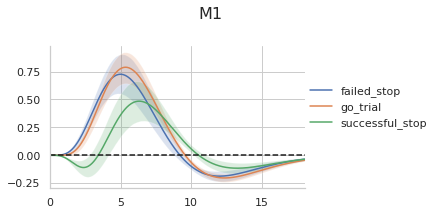

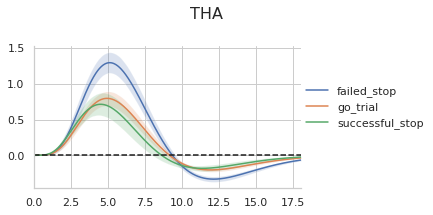

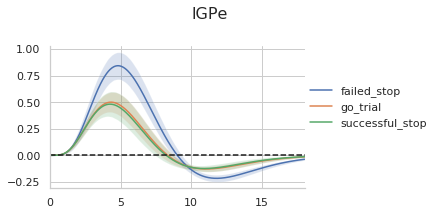

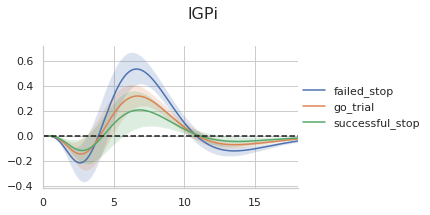

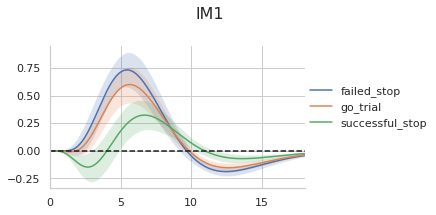

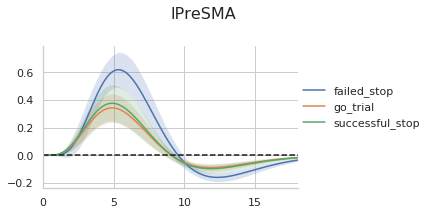

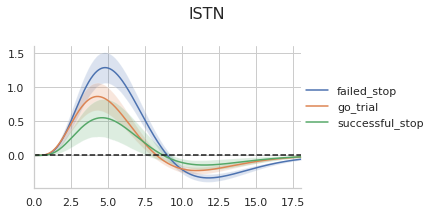

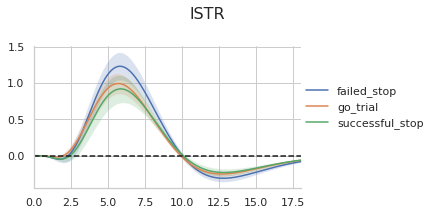

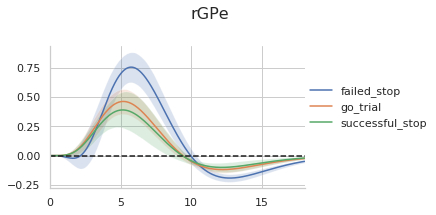

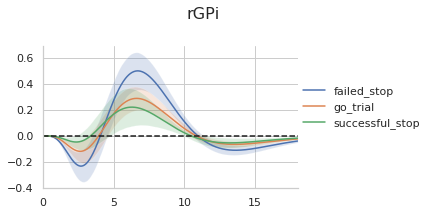

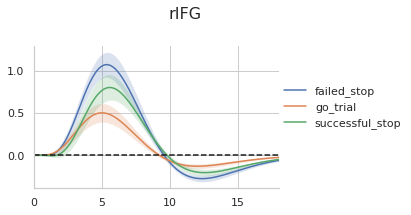

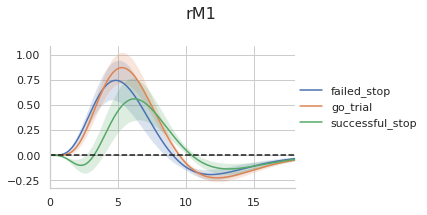

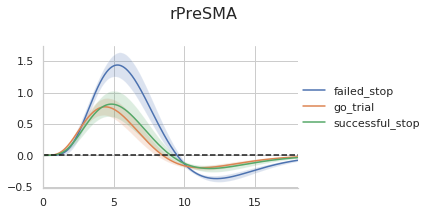

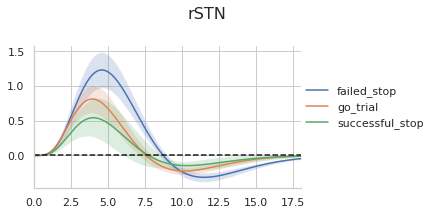

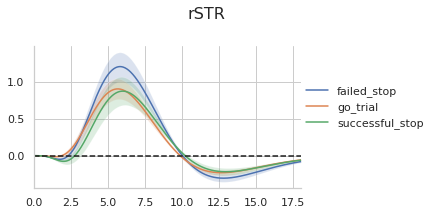

In [117]:
rfGroups_canonicalHRF_with_d['psc']['se'].plot_groupwise_timecourses()

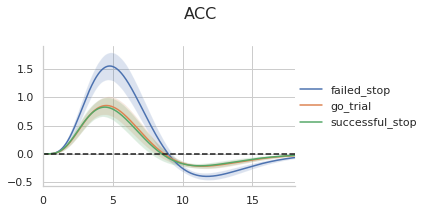

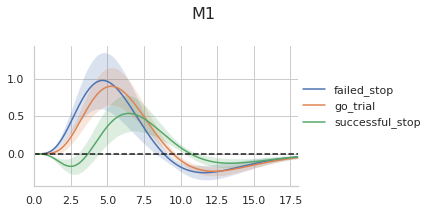

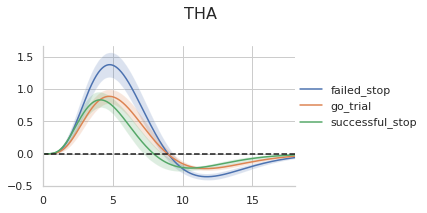

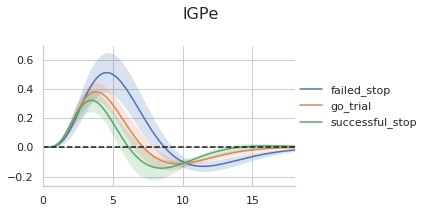

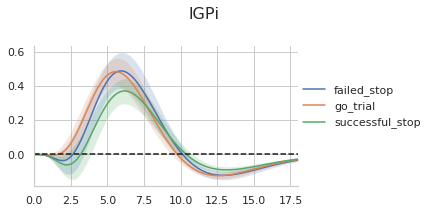

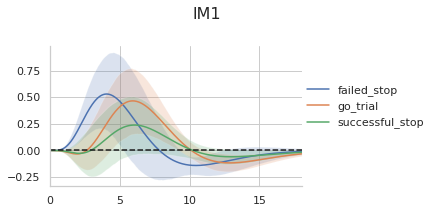

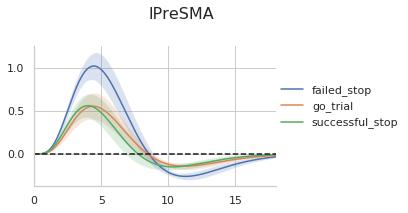

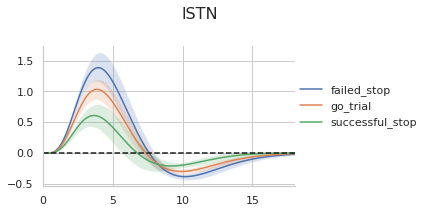

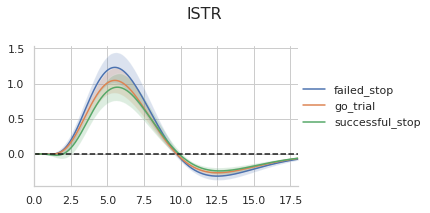

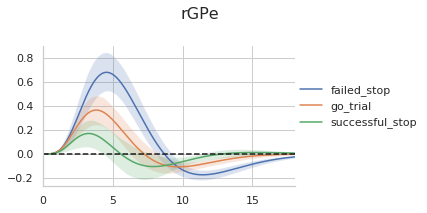

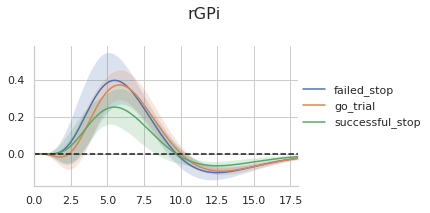

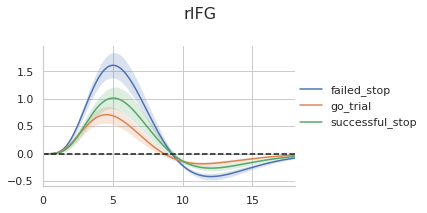

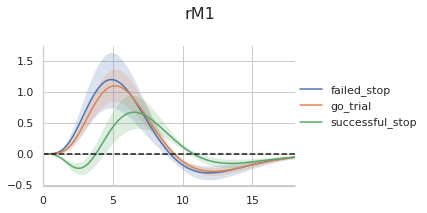

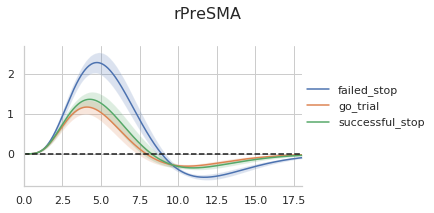

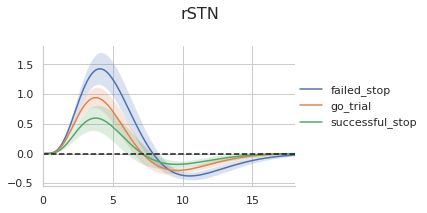

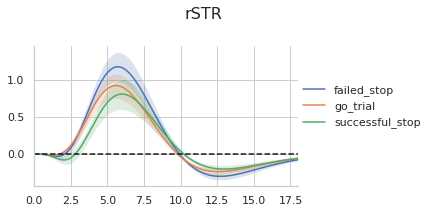

In [90]:
rfGroups_canonicalHRF_with_d['psc']['optcomb'].plot_groupwise_timecourses()

lSTN..rSTN..rSTR..rIFG..

(<Figure size 576x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74cb123cc0>,
       dtype=object))

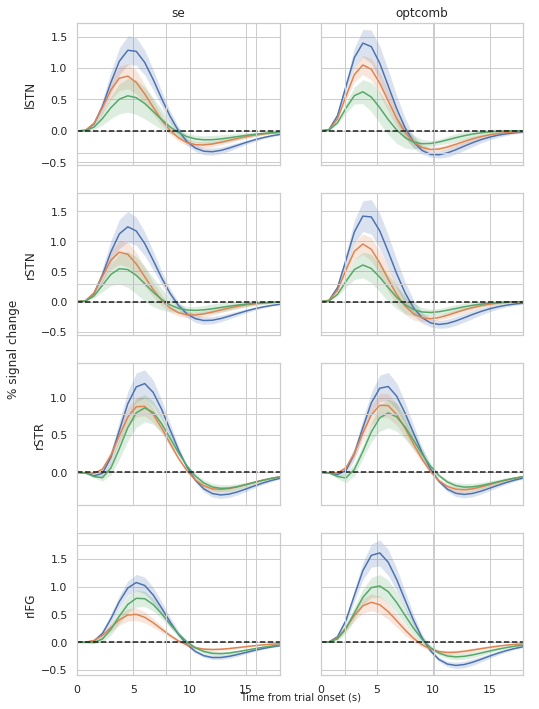

In [16]:
make_plot(rfGroups_canonicalHRF_with_d['psc'], 
          y_label='% signal change',
          columns=['se', 'optcomb'], 
          masks=['lSTN', 'rSTN', 'rSTR', 'rIFG'], 
          data_type='psc', 
          oversample=4)

In [136]:
rfGroups_canonicalHRF = {'psc': {}}

masks = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'lGPe', 'rGPe', 'lPreSMA', 'rPreSMA', 'M1', 'rIFG']
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    for standardization in rfGroups_canonicalHRF.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = get_session_timeseries(ses, standardize=standardization)
        onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
        onsets['onset'] -= 1.5
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., oversample_design_matrix=1, 
                                               concatenate_runs=False,
                                               event_type=('go_trial', 'successful_stop', 'failed_stop'))
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf')
        rfGroup.fit(concatenate_runs=False)

        rfGroups_canonicalHRF[standardization][ses] = rfGroup

rfGroups_canonicalHRF
#basis_set='canonical_hrf_with_time_derivative'

Data: se...psc...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

{'psc': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7f0c0f2b3518>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7f0c0de12a58>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7f0c0cf884e0>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7f0c0cf9a278>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7f0c0caa7cc0>}}

lSTN..rSTN..rSTR..rIFG..

(<Figure size 576x864 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c0d0d2278>,
       dtype=object))

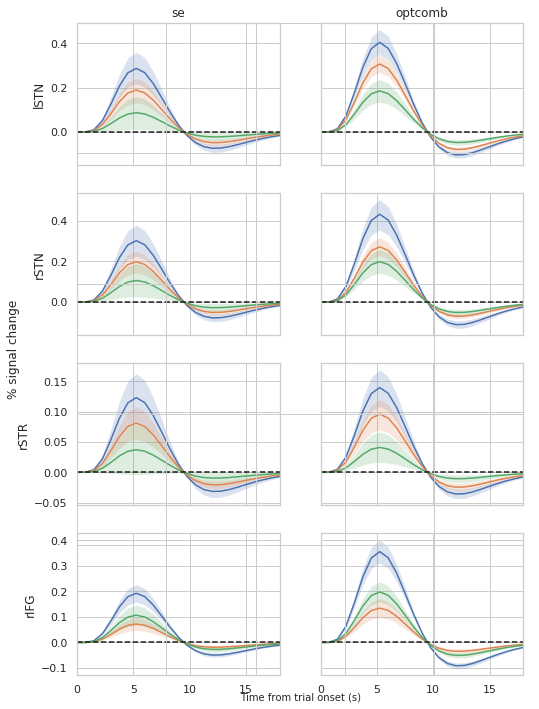

In [137]:
make_plot(rfGroups_canonicalHRF['psc'], 
          y_label='% signal change',
          columns=['se', 'optcomb'], 
          masks=['lSTN', 'rSTN', 'rSTR', 'rIFG'], 
          data_type='psc', 
          oversample=4)

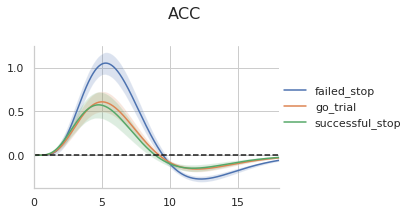

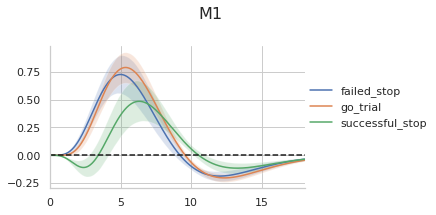

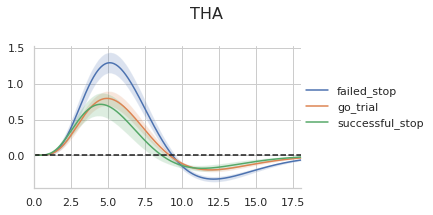

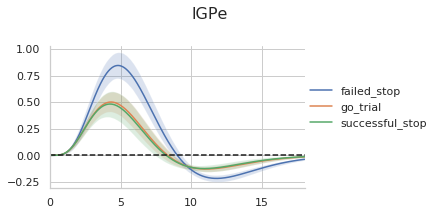

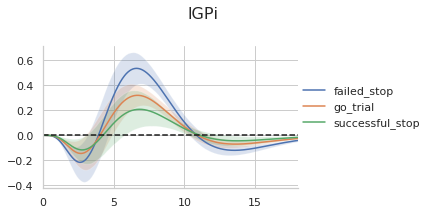

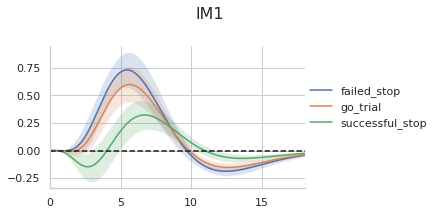

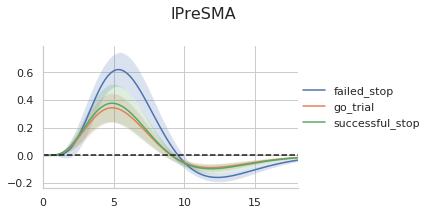

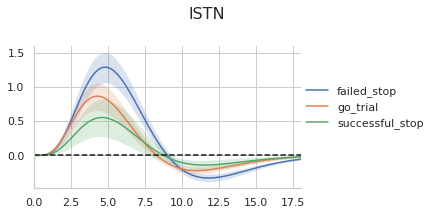

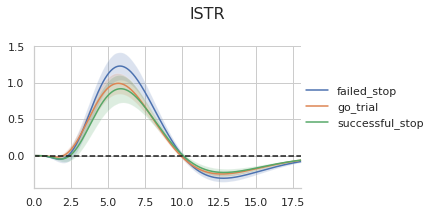

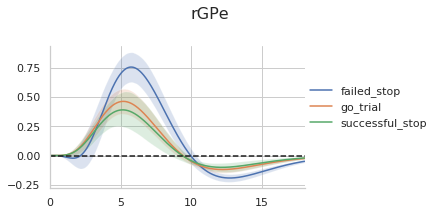

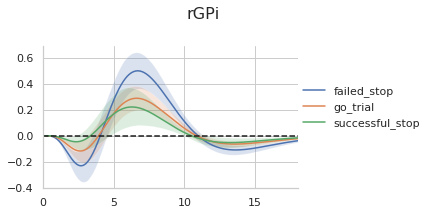

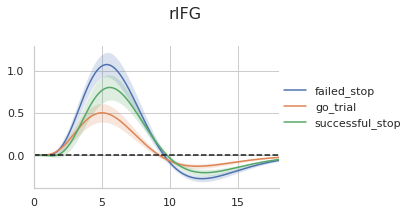

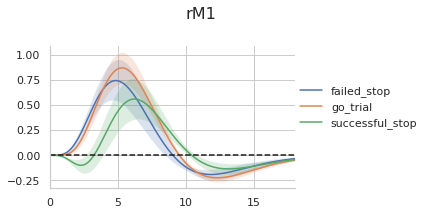

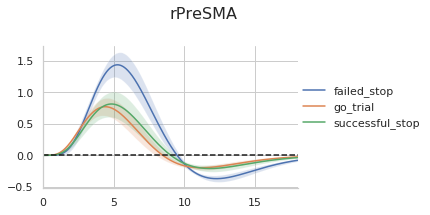

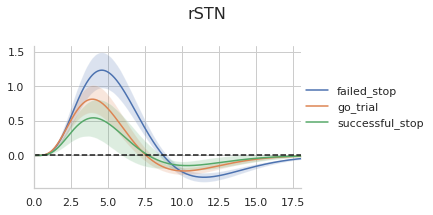

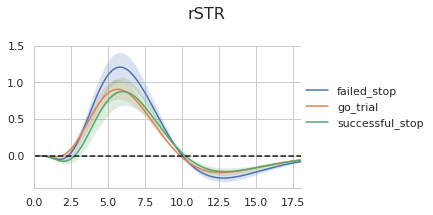

In [138]:
rfGroups_canonicalHRF_with_d['psc']['se'].plot_groupwise_timecourses()

## Deconvolution of CSF signal

One of the interesting/worrying results of the GLMs (SPMs of the derivatives) is a negative deflection in CSF.
Here, we deconvolve CSF to have a look at the "BOLD"-response - there should be nothing there...

First, find CSF of each subject, and downsample to 1p6mm-space for EPIs

In [3]:
import nighres

In [ ]:
def make_masks_singlesub(sub):
    csf_probmap_mni09c = csf_probmap_template.format(str(sub).zfill(2), str(sub).zfill(2))
    
    # "warp"
    output_dir = './masks/masks_csf_mni09c_1p6'
    warp_res = nighres.registration.apply_coordinate_mappings(csf_probmap_mni09c, mapping1=mapping,
                                                              save_data=True, output_dir=output_dir)
    
    # Erode brain mask with fslmaths
    mask = './data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(str(sub).zfill(2), str(sub).zfill(2))
    for i in [1,2,3,4,5]:
        out = './masks/brain_masks_eroded_mni09c_1p6/sub-{}_brain_mask_eroded_10mm-{}.nii.gz'.format(str(sub).zfill(2), i)
        if i == 1:
            in_ = mask
        else:
            in_ = './masks/brain_masks_eroded_mni09c_1p6/sub-{}_brain_mask_eroded_10mm-{}.nii.gz'.format(str(sub).zfill(2), i-1)
        cmd = ['fslmaths', in_, '-kernel', 'box', '10x10x10', '-ero', out]
        cmd = ' '.join(cmd)
        os.system(cmd)

import multiprocessing as mp
with mp.Pool(10) as p:
    p.map(make_masks_singlesub, np.arange(1, 19))

In [44]:
## combine eroded brain mask with CSF mask
def combine_masks(brain_mask, csf_mask, make_4D=True):
    if isinstance(brain_mask, str):    
        brain = nib.load(brain_mask)
        csf = nib.load(csf_mask)
    
    brain_dat = brain.get_data()
    csf_dat = csf.get_data()
    
    csf_dat[brain_dat==0] = 0
    csf_dat[csf_dat<1] = 0
    
    if make_4D:
        csf_dat = csf_dat[:,:,:,np.newaxis]
    
    return nib.Nifti1Image(csf_dat, csf.affine)

brain_mask = './masks/brain_masks_eroded_mni09c_1p6/sub-{}_brain_mask_eroded_10mm-{}.nii.gz'.format(str(sub).zfill(2), 5)
csf_mask = './masks/masks_csf_mni09c_1p6/sub-{}_space-MNI152NLin2009cAsym_label-CSF_probseg_def-img.nii.gz'.format(str(sub).zfill(2))

combmask = combine_masks(brain_mask, csf_mask)

In [45]:
def mp_helper2(to_run, **kwargs):
    
    sub = to_run[1]
    if sub == 12:
        return 0
    
    brain_mask = './masks/brain_masks_eroded_mni09c_1p6/sub-{}_brain_mask_eroded_10mm-{}.nii.gz'.format(str(sub).zfill(2), 5)
    csf_mask = './masks/masks_csf_mni09c_1p6/sub-{}_space-MNI152NLin2009cAsym_label-CSF_probseg_def-img.nii.gz'.format(str(sub).zfill(2))
    combmask = combine_masks(brain_mask, csf_mask)
    
    mp_helper(to_run, atlas_maps=combmask, atlas_labels=['csf'], **kwargs)

In [63]:
import itertools
import multiprocessing as mp
from functools import partial

subs = np.arange(1, 19)
runs = [1,2,3]
ses = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
to_run = list(itertools.product(ses, subs, runs))

with mp.Pool(10) as p:
    p.map(partial(mp_helper2, overwrite=False, cache_fn='./deconvolution_cache_csf/'), to_run)

Sub 10, ses/echo/combination echo_1, run 1...
Sub 01, ses/echo/combination echo_1, run 1...
Sub 13, ses/echo/combination echo_1, run 2...
Sub 08, ses/echo/combination echo_1, run 3...
Sub 14, ses/echo/combination echo_1, run 3...
Sub 07, ses/echo/combination echo_2, run 3...
Sub 03, ses/echo/combination echo_2, run 2...
Sub 17, ses/echo/combination echo_1, run 1...
Sub 05, ses/echo/combination echo_2, run 3...
Sub 01, ses/echo/combination echo_2, run 2...
Sub 08, ses/echo/combination echo_2, run 1...
Sub 10, ses/echo/combination echo_1, run 2...
Sub 13, ses/echo/combination echo_1, run 3...
Sub 03, ses/echo/combination echo_2, run 3...
Sub 15, ses/echo/combination echo_1, run 1...
Sub 01, ses/echo/combination echo_2, run 3...
Sub 01, ses/echo/combination echo_1, run 2...
Sub 09, ses/echo/combination echo_1, run 1...
Sub 06, ses/echo/combination echo_2, run 1...
Sub 17, ses/echo/combination echo_1, run 2...
Sub 08, ses/echo/combination echo_2, run 2...
Sub 10, ses/echo/combination echo_

In [52]:
# ok, now deconvolve again

In [118]:
# sub_str = '01'
# run = 1
# ts2 = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
# ts2['csf']
# ts2

In [151]:
def get_all_csf_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache_csf/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache_csf/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache_csf/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache_csf/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat

def get_session_csf_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ## WARNING: WRONG
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
                
#             ts = get_all_csf_ts(sub, ses, run)
            
            # set on common scale across runs
#             if standardize == 'psc':
#                 ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
#             elif standardize == 'zscore':
#                 ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat


In [43]:
rfGroups = {'psc': {}}

for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')

    for standardization in rfGroups.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = get_session_csf_timeseries(ses, standardize=standardization)
        onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., oversample_design_matrix=100, concatenate_runs=False)
        rfGroup.add_event(interval=[0,18], n_regressors=7)
        rfGroup.fit(concatenate_runs=False)

        rfGroups[standardization][ses] = rfGroup

rfGroups

Data: se...psc...

Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

{'psc': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ed99c7f0>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9f244b898>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ebacc278>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ebaf1dd8>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9eb657eb8>}}

csf.....

(<Figure size 1440x216 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9eade5940>,
       dtype=object))

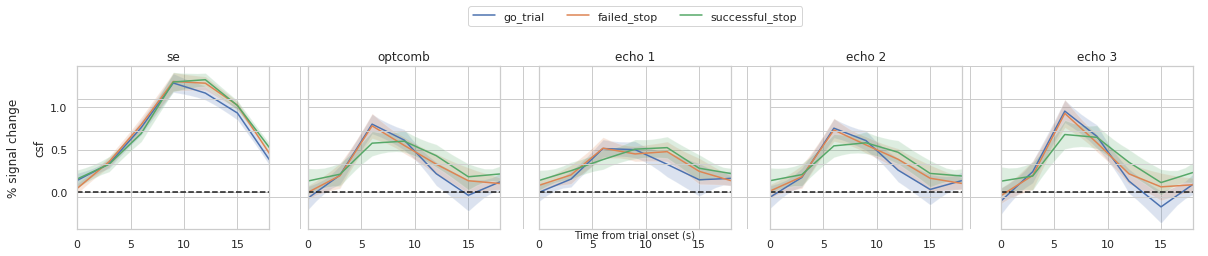

In [45]:
# make_plot(rfGroups['psc'],
#           y_label='% signal change',
#           columns=['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3'], 
#           masks=['csf'],
#           data_type='psc',
#           oversample=4)

In [46]:
# rfGroups = {'psc': {}}

# for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
#     print('Data: {}...'.format(ses), end='')

#     for standardization in rfGroups.keys():
#         print('{}...'.format(standardization), end='')
#         # get relevant data
#         ts = get_session_csf_timeseries(ses, standardize=standardization)
#         onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))

#         # deconvolve
#         rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., oversample_design_matrix=100, concatenate_runs=False)
#         rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf')
#         rfGroup.fit(concatenate_runs=False)

#         rfGroups[standardization][ses] = rfGroup

# rfGroups

Data: se...psc...

Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

{'psc': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9eb224048>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9eb68f668>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ea6f6f98>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ea606be0>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9ea215cc0>}}

csf.....

(<Figure size 1440x216 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9f1984048>,
       dtype=object))

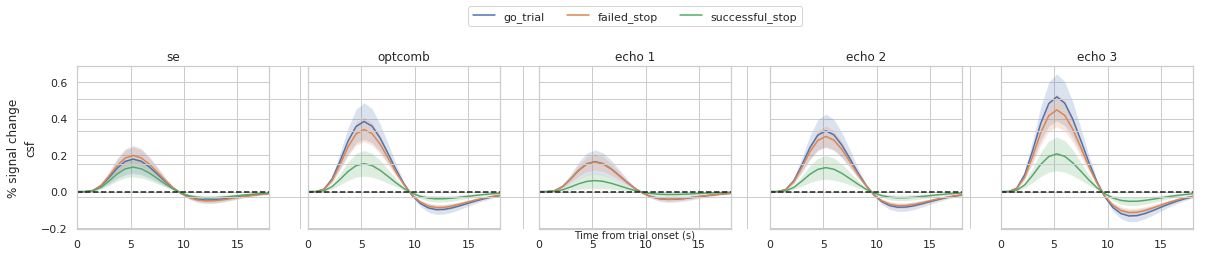

In [47]:
# make_plot(rfGroups['psc'],
#           y_label='% signal change',
#           columns=['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3'], 
#           masks=['csf'],
#           data_type='psc',
#           oversample=4)

In [48]:
# rfGroups = {'psc': {}}

# for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
#     print('Data: {}...'.format(ses), end='')

#     for standardization in rfGroups.keys():
#         print('{}...'.format(standardization), end='')
#         # get relevant data
#         ts = get_session_csf_timeseries(ses, standardize=standardization)
#         onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))

#         # deconvolve
#         rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., oversample_design_matrix=100, concatenate_runs=False)
#         rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative')
#         rfGroup.fit(concatenate_runs=False)

#         rfGroups[standardization][ses] = rfGroup

# rfGroups

Data: se...psc...

Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

{'psc': {'se': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9e99d0208>,
  'optcomb': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9e944e668>,
  'echo_1': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9e8e5d668>,
  'echo_2': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9e8a6ea90>,
  'echo_3': <nideconv.group_analysis.GroupResponseFitter at 0x7fe9e8636ac8>}}

csf.....

(<Figure size 1440x216 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9eab813c8>,
       dtype=object))

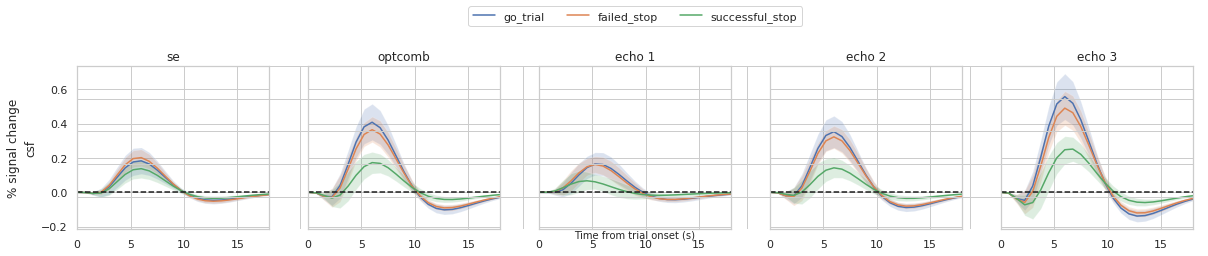

In [49]:
# make_plot(rfGroups['psc'],
#           y_label='% signal change',
#           columns=['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3'], 
#           masks=['csf'],
#           data_type='psc',
#           oversample=4)

## Extract betas of GLMs

In [104]:
from nilearn.image import index_img
def apply_mask(img, mask):
    img_data = img.get_data()
    mask_data = mask.get_data()
    
    # apply binary mask
    mask_binary = mask_data > 0
    mask_trimmed = mask_data[mask_binary]
    img_data_trimmed = img_data[mask_binary]
    
    return np.average(img_data_trimmed, weights=mask_trimmed)

def _get_roi_idx(label, atlas_labels):
    return list(roi_atlas.labels).index(label)

def _get_session_fn(session, sub):
    if session == 'se':
        return "data/deriv/fmriprep/sub-{}/ses-se/model_onset-shift/firstlevel_fwhm-0.pkl".format(str(sub).zfill(2))
    else:
        return "data/deriv/fmriprep/sub-{}/ses-me/model_onset-shift/firstlevel_fwhm-0_comb-optcomb.pkl".format(str(sub).zfill(2))

In [105]:
from itertools import product
subs = [x for x in np.arange(1,19) if not x == 12]
contrasts = ['go_trial', 'failed_stop', 'successful_stop', 'failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial']
sessions  = ['se', 'me']
rois = list(roi_atlas.labels)

tval_df = pd.DataFrame(list(product(subs, sessions, rois, contrasts)), columns=['subject', 'session', 'roi', 'contrast'])
tval_df['beta-value'] = np.nan
tval_df['variance'] = np.nan

In [249]:
# # load single design matrix to get all contrasts
# session='se'
# with open(_get_session_fn(session, 1), 'rb') as f:
#     model = pkl.load(f)
# design_matrix = model.design_matrices_[0]

# contrast_matrix = np.eye(design_matrix.shape[1])
# contrasts = dict([(column, contrast_matrix[i])
#                   for i, column in enumerate(design_matrix.columns)])

In [106]:
# loop over subjects,s essions, contrasts to fill DataFrame

for sub in np.arange(1,19):
    print('\nSub {} '.format(sub), end='')
    if sub == 12:
        continue
    
    # single echo first
    for session in sessions:
        print('session {} '.format(session), end='')
        with open(_get_session_fn(session, sub), 'rb') as f:
            model = pkl.load(f)
    
        for contrast in contrasts:
#            print('contrast {} '.format(contrast), end='')
            nii = model.compute_contrast(contrast, output_type='effect_size')
            nii_var = model.compute_contrast(contrast, output_type='effect_variance')

            for roi in rois:
                mean_beta = apply_mask(nii, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))
                mean_var = apply_mask(nii_var, index_img(roi_atlas.maps, _get_roi_idx(roi, roi_atlas.labels)))
                
                tval_df.loc[(tval_df['subject'] == sub) & \
                            (tval_df['session'] == session) & \
                            (tval_df['roi'] == roi) & \
                            (tval_df['contrast'] == contrast), 'beta-value'] = mean_beta
                tval_df.loc[(tval_df['subject'] == sub) & \
                            (tval_df['session'] == session) & \
                            (tval_df['roi'] == roi) & \
                            (tval_df['contrast'] == contrast), 'variance'] = mean_var


Sub 1 session se 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/utils.py:286: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


session me 
Sub 2 session se session me 
Sub 3 session se session me 
Sub 4 session se session me 
Sub 5 session se session me 
Sub 6 session se session me 
Sub 7 session se session me 
Sub 8 session se session me 
Sub 9 session se session me 
Sub 10 session se session me 
Sub 11 session se session me 
Sub 12 
Sub 13 session se session me 
Sub 14 session se session me 
Sub 15 session se session me 
Sub 16 session se session me 
Sub 17 session se 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


session me 
Sub 18 session se session me 

In [259]:
stats.ttest_1samp

<function scipy.stats.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate')>

In [276]:
tval_df

,subject,session,roi,contrast,beta-value,variance
0,1,se,ACC,go_trial,2.615356,12.229112
1,1,se,ACC,failed_stop,2.411012,28.447470
2,1,se,ACC,successful_stop,1.243637,30.140883
3,1,se,ACC,failed_stop - go_trial,-0.204344,23.056468
4,1,se,ACC,failed_stop - successful_stop,1.167375,41.588843
5,1,se,ACC,successful_stop - go_trial,-1.371719,25.413330
6,1,se,M1,go_trial,4.153588,1236.686220
7,1,se,M1,failed_stop,2.157819,3171.972803
8,1,se,M1,successful_stop,0.174967,3848.376155
9,1,se,M1,failed_stop - go_trial,-1.995768,2796.941827


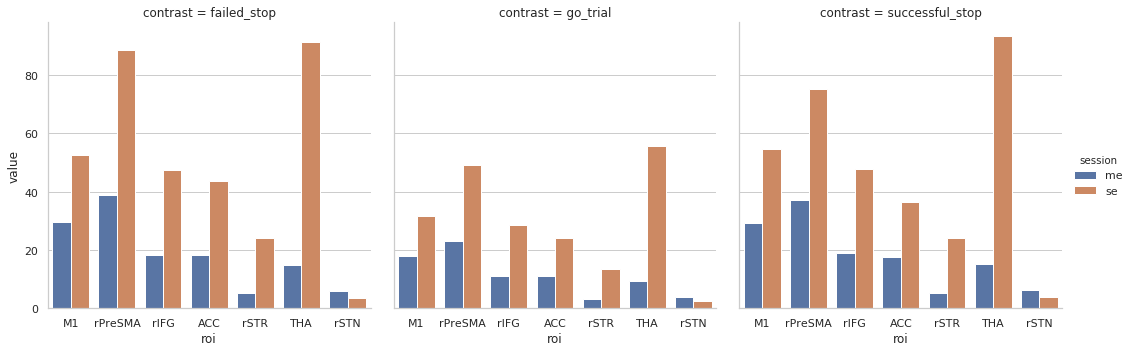

In [278]:
def make_plottable(df, values, contrasts, apply_func=None):
    df = pd.pivot_table(df, values=values, index=['session', 'subject', 'roi'], columns='contrast')
#    df = df[values]
    
    df = df.reset_index().melt(['subject', 'session', 'roi'])
    df = df.loc[np.in1d(df['contrast'], contrasts)]
    
    if apply_func is None:
        return df
    elif apply_func == 't':
        df = df.groupby(['session', 'contrast', 'roi'])['value'].apply(lambda x: stats.ttest_1samp(x, 0)[0]).reset_index()
    else:
        df = df.groupby(['session', 'contrast', 'roi'])['value'].apply(apply_func).reset_index()
    return df

df = make_plottable(tval_df, 'variance', ['failed_stop', 'go_trial', 'successful_stop'], apply_func=np.mean)
df['value'] = np.sqrt(df['value'])
sns.catplot(x='roi', y='value', hue='session', col='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=df.loc[np.in1d(df.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

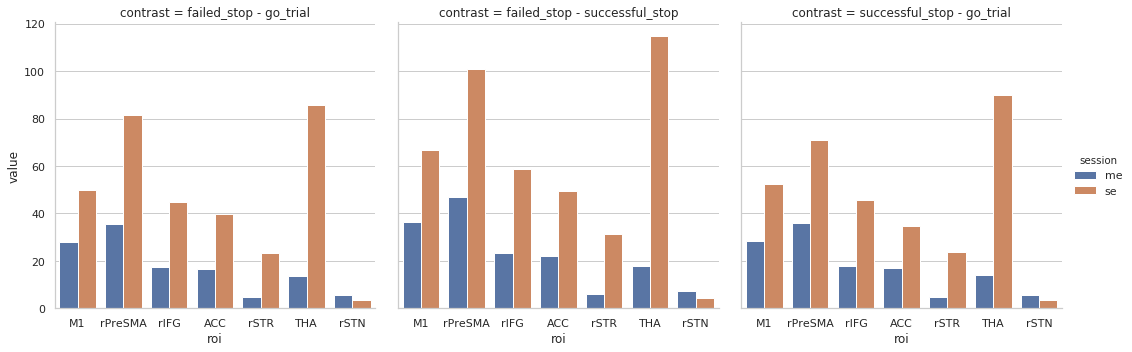

In [280]:
df = make_plottable(tval_df, 'variance', 
                    ['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'], 
                    apply_func=np.mean)
df['value'] = np.sqrt(df['value'])

sns.catplot(x='roi', y='value', hue='session', col='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=df.loc[np.in1d(df.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

In [251]:
pivotted = pd.pivot_table(tval_df, values=['beta-value'], index=['session', 'subject', 'roi'], columns='contrast')
pivotted = pivotted['beta-value']
# pivotted['failed_stop_corrected'] = np.sign(pivotted['failed_stop'])*np.sqrt(pivotted['failed_stop']**2 + pivotted['failed_stop_derivative']**2)
# pivotted['go_trial_corrected'] = np.sign(pivotted['go_trial'])*np.sqrt(pivotted['go_trial']**2 + pivotted['go_trial_derivative']**2)
# pivotted['successful_stop_corrected'] = np.sign(pivotted['successful_stop'])*np.sqrt(pivotted['successful_stop']**2 + pivotted['successful_stop_derivative']**2)

In [252]:
cleaned = pivotted.reset_index().melt(['subject', 'session', 'roi'])
# cleaned = cleaned.loc[np.in1d(cleaned['contrast'], ['failed_stop_corrected', 'go_trial_corrected', 'successful_stop_corrected'])]
cleaned = cleaned.loc[np.in1d(cleaned['contrast'], ['failed_stop', 'go_trial', 'successful_stop'])]
cleaned.head()

,subject,session,roi,contrast,value
0,1,me,ACC,failed_stop,1.840540
1,1,me,M1,failed_stop,1.270278
2,1,me,THA,failed_stop,3.392887
3,1,me,lGPe,failed_stop,0.252406
4,1,me,lGPi,failed_stop,0.728120


In [233]:
from scipy import stats
cleaned_t = cleaned.groupby(['session', 'roi', 'contrast']).apply(lambda x: stats.ttest_1samp(x, 0)[0][1]).reset_index()
cleaned_t.rename(columns={0: 'value'}, inplace=True)

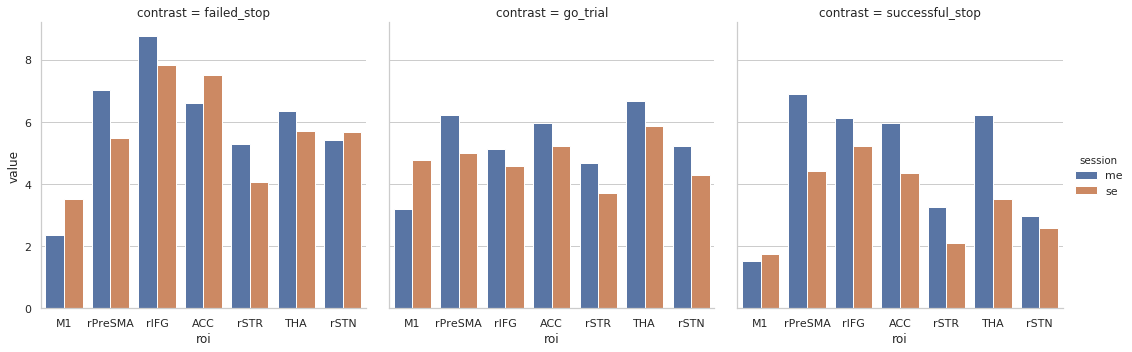

In [234]:
sns.catplot(x='roi', y='value', hue='session', col='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=cleaned_t.loc[np.in1d(cleaned_t.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

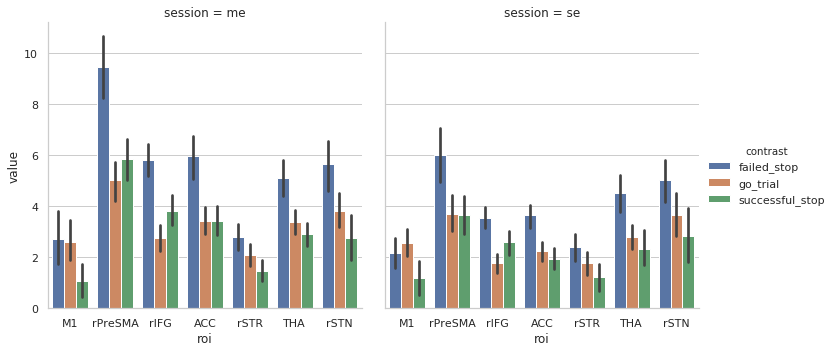

In [239]:
sns.catplot(x='roi', y='value', hue='contrast', col='session', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=cleaned.loc[np.in1d(cleaned.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

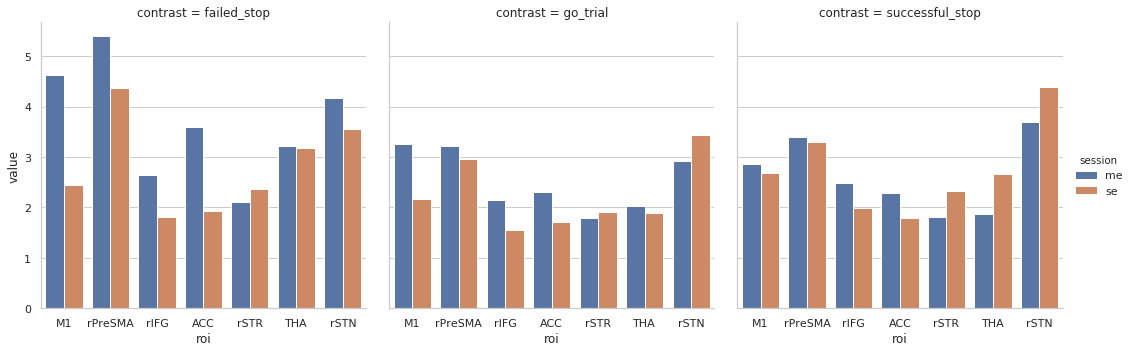

In [247]:
cleaned_sd = cleaned.groupby(['session', 'roi', 'contrast'])['value'].apply(np.std).reset_index()

sns.catplot(x='roi', y='value', hue='session', col='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=cleaned_sd.loc[np.in1d(cleaned_sd.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

In [228]:
# ok, now contrasts
cleaned = pivotted.reset_index().melt(['subject', 'session', 'roi'])
# cleaned = cleaned.loc[np.in1d(cleaned['contrast'], ['failed_stop_corrected', 'go_trial_corrected', 'successful_stop_corrected'])]
cleaned = cleaned.loc[np.in1d(cleaned['contrast'], ['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])]
cleaned_t = cleaned.groupby(['session', 'roi', 'contrast']).apply(lambda x: stats.ttest_1samp(x, 0)[0][1]).reset_index()
cleaned_t.rename(columns={0: 'value'}, inplace=True)

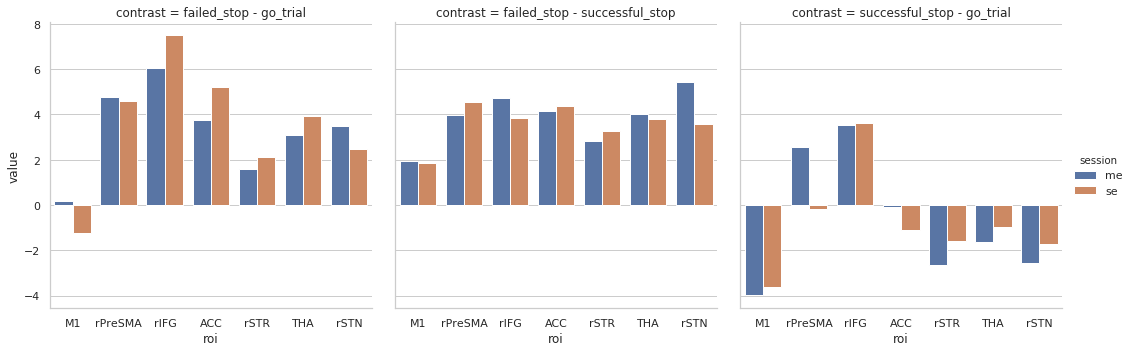

In [229]:
sns.catplot(x='roi', y='value', hue='session', col='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=True,
            data=cleaned_t.loc[np.in1d(cleaned_t.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

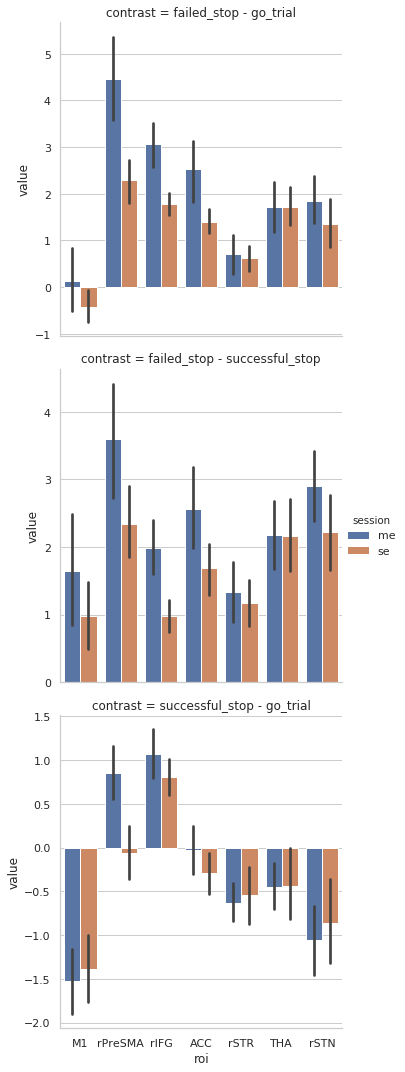

In [192]:
sns.catplot(x='roi', y='value', hue='session', row='contrast', ci=67, kind='bar', 
            order=['M1', 'rPreSMA', 'rIFG', 'ACC', 'rSTR', 'THA', 'rSTN'], sharey=False,
            data=cleaned.loc[np.in1d(cleaned.roi, ['rSTN', 'rIFG', 'rSTR', 'THA', 'M1', 'rPreSMA', 'ACC'])])

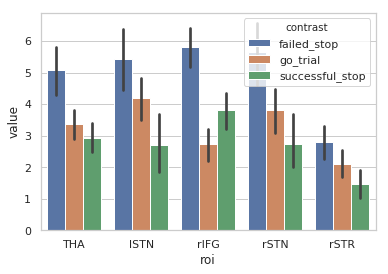

In [71]:
sns.barplot(x='roi', y='value', hue='contrast', ci=67,
            data=cleaned.loc[(cleaned.session=='me') & 
                             np.in1d(cleaned.roi, ['rSTN', 'lSTN', 'rIFG', 'rSTR', 'THA'])])

In [46]:
failed_stop = tval_df.groupby(['session', 'subject', 'roi'])

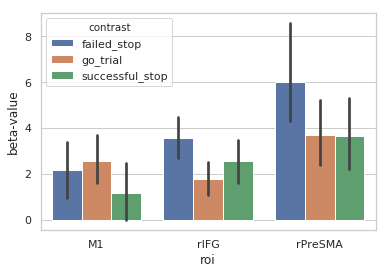

In [53]:
cort_rois = ['rIFG', 'M1', 'rPreSMA']
subcort_rois = ['rSTN', 'lSTN', 'rSTR', 'lSTR']

sns.barplot(x='roi', y='beta-value', hue='contrast', 
            data=tval_df.loc[(tval_df.session=='se') & \
                             (np.in1d(tval_df.contrast.values, ['go_trial', 'successful_stop', 'failed_stop'])) & \
                             (np.in1d(tval_df.roi.values, cort_rois))
                            ])

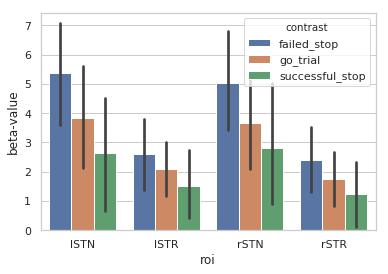

In [55]:
cort_rois = ['rIFG', 'M1', 'rPreSMA']
subcort_rois = ['rSTN', 'lSTN', 'rSTR', 'lSTR']

sns.barplot(x='roi', y='beta-value', hue='contrast', 
            data=tval_df.loc[(tval_df.session=='se') & \
                             (np.in1d(tval_df.contrast.values, ['go_trial', 'successful_stop', 'failed_stop'])) & \
                             (np.in1d(tval_df.roi.values, subcort_rois))])

In [57]:
# cort_rois = ['rIFG', 'M1', 'rPreSMA']
# subcort_rois = ['rSTN', 'lSTN', 'rSTR', 'lSTR']
# contrasts2plot = ['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial']

# sns.barplot(x='roi', y='beta-value', hue='contrast', 
#             data=tval_df.loc[(tval_df.session=='se') & \
#                              (np.in1d(tval_df.contrast.values, contrasts2plot)) & \
#                              (np.in1d(tval_df.roi.values, subcort_rois))])

In [58]:
# cort_rois = ['rIFG', 'M1', 'rPreSMA']
# subcort_rois = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'THA']
# contrasts2plot = ['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial']

# sns.barplot(x='roi', y='t-value', hue='contrast', 
#             data=tval_df.loc[(tval_df.session=='se') & \
#                              (np.in1d(tval_df.contrast.values, contrasts2plot)) & \
#                              (np.in1d(tval_df.roi.values, subcort_rois))])

In [ ]:
for idx, label in enumerate(roi_atlas.labels):
    go_mean = []
    failed_stop_mean = []
    successful_stop_mean = []
    
    for contr in go_trials:
        go_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
    for contr in failed_stop:
        failed_stop_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
    for contr in successful_stop:
        successful_stop_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
        
    print('{}: go: {}, successful stop: {}, failed stop: {}'.format(label, 
                                                                    np.round(np.mean(go_mean), 3), 
                                                                    np.round(np.mean(successful_stop_mean), 3), 
                                                                    np.round(np.mean(failed_stop_mean), 3)))

### t-values: multi-echo

In [ ]:
go_trials = []
failed_stop = []
successful_stop = []
for sub in np.arange(1,19):
    if sub == 12:
        continue
    
    with open("data/deriv/fmriprep/sub-{}/ses-me/model/firstlevel_fwhm-0_comb-optcomb.pkl".format(str(sub).zfill(2)), 'rb') as f:
        model = pkl.load(f)
        go_trials.append(model.compute_contrast('go_trial', output_type='effect_size', stat_type='t'))
        failed_stop.append(model.compute_contrast('failed_stop', output_type='effect_size', stat_type='t'))
        successful_stop.append(model.compute_contrast('successful_stop', output_type='effect_size', stat_type='t'))

In [ ]:
for idx, label in enumerate(roi_atlas.labels):
    go_mean = []
    failed_stop_mean = []
    successful_stop_mean = []
    
    for contr in go_trials:
        go_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
    for contr in failed_stop:
        failed_stop_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
    for contr in successful_stop:
        successful_stop_mean.append(apply_mask(contr, index_img(roi_atlas.maps, idx)))
        
    print('{}: go: {}, successful stop: {}, failed stop: {}'.format(label, 
                                                                    np.round(np.mean(go_mean), 3), 
                                                                    np.round(np.mean(successful_stop_mean), 3), 
                                                                    np.round(np.mean(failed_stop_mean), 3)))

In [ ]:
## contrasts: single echo

In [ ]:
go_trials = []
failed_stop = []
successful_stop = []
for sub in np.arange(1,19):
    if sub == 12:
        continue
    
    with open("data/deriv/fmriprep/sub-{}/ses-se/model/firstlevel_fwhm-0.pkl".format(str(sub).zfill(2)), 'rb') as f:
        model = pkl.load(f)
        go_trials.append(model.compute_contrast('go_trial', output_type='stat', stat_type='t'))
        failed_stop.append(model.compute_contrast('failed_stop', output_type='stat', stat_type='t'))
        successful_stop.append(model.compute_contrast('successful_stop', output_type='stat', stat_type='t'))

In [ ]:
import pickle as pkl

with open("data/deriv/fmriprep/sub-01/ses-se/model/contrasts_fwhm-0.pkl", 'rb') as f:
    contr = pkl.load(f)

In [ ]:
import nilearn
from nilearn import plotting
plotting.plot_stat_map(contr['failed_stop - go_trial'])

In [ ]:
import nilearn
from nilearn import plotting
plotting.plot_stat_map(contr['failed_stop - successful_stop'])

In [ ]:
first_level_model = FirstLevelModelSM(self.t_r, 
                                      hrf_model='glover + derivative', 
                                      smoothing_fwhm=smoothing_fwhm,
                                      mask=mask,
                                      n_jobs=n_jobs, **kwargs)
#             print(data)
paradigm = [self.get_onsets(x, events=events) for x in self.runs]
first_level_model.fit(data, paradigm)

In [ ]:
import numpy as np
tr = 3.0  # repetition time is 1 second
n_scans = 343  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# get events
events = get_event_data('01', 'se', 1)

hrf_model = 'glover + derivative'
from nistats.design_matrix import make_first_level_design_matrix
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model=None, drift_order=None,
    hrf_model=hrf_model)

In [ ]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(X1)

In [ ]:
ses = 'se'
masks = ['ACC', 'M1', 'lGPe', 'lGPi', 'lM1', 'lPreSMA', 'lSTN', 'lSTR', 'rGPe', 'rGPi', 'rIFG', 'rM1', 'rPreSMA', 'rSTN', 'rSTR']
flms = []
for sub in np.arange(1, 19):
    print('{}... '.format(sub), end='')
    this_sub_niis = []
    if sub == 12:
        continue
    if sub == 17:
        runs = [1,2]
    else:
        runs = [1,2,3]

    for run in runs:
        Y = get_all_ts(sub, ses, run)[masks] #.values

        # make nii
        Y_np = Y.values.reshape((Y.shape[1], 1, 1, Y.shape[0]))
        this_sub_niis.append(nib.Nifti1Image(Y_np, affine=np.eye(4)))
    
    # get onsets
    paradigm = [get_event_data(str(sub).zfill(2), ses, run) for run in runs]

    # generate mask
    mask = nib.Nifti1Image(np.ones((Y.shape[0], 1, 1)), np.eye(4))
    flm = nistats.first_level_model.FirstLevelModel(t_r=3., 
                                                    drift_model=None,
                                                    mask=mask,
                                                    hrf_model='glover + derivative',
                                                    n_jobs=1)
    flm.fit(this_sub_niis, paradigm, confounds=None)
    flms.append(flm)

In [ ]:
from nistats.second_level_model import SecondLevelModel

second_level_model = SecondLevelModel()

In [ ]:
flms[0].design_matrices_[0].shape[1]

In [ ]:
dm = flms[0].design_matrices_[0]
contrast_matrix = np.eye(flms[0].design_matrices_[0].shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(dm.columns)])

In [ ]:
cmaps = [fl]
second_level_model.fit(cmaps, design_matrix = pd.DataFrame([1] * len(cmaps)))
zm = second_level_model.compute_contrast(output_type='effect_size')

In [ ]:
cmaps = [flm.compute_contrast('successful_stop - go_trial') for flm in flms]
second_level_model.fit(cmaps, design_matrix = pd.DataFrame([1] * len(cmaps)))
zm = second_level_model.compute_contrast(output_type='effect_size')
dict(zip(masks, zm.get_data().reshape(-1)))
#zm.get_data()

In [ ]:
cmaps = [flm.compute_contrast('go_trial - successful_stop', stat_type='t', output_type='stat') for flm in flms]
second_level_model.fit(cmaps, design_matrix = pd.DataFrame([1] * len(cmaps)))
zm = second_level_model.compute_contrast(output_type='stat')
dict(zip(masks, zm.get_data().reshape(-1)))
#zm.get_data()

In [ ]:
contr = second_level_model.compute_contrast(first_level_contrast=['go_trial - constant'])

In [ ]:
contr.get_data()

In [ ]:
masks

In [ ]:
contr = second_level_model.compute_contrast(first_level_contrast=['failed_stop - go_trial'])
contr.get_data().reshape(-1)

In [ ]:
dict(zip(masks, contr.get_data().reshape(-1)))

In [ ]:
this_sub_niis

In [ ]:
contr = flm.compute_contrast(('go_trial'))

In [ ]:
contr.shape

In [ ]:
contr.get_data().reshape((contr.shape[0]))

In [ ]:
import nilearn

In [ ]:
Y = Y.reshape((17,1,1,343))

In [ ]:
import nibabel as nib
nii_ = nib.Nifti1Image(Y, affine=np.eye(4))

In [ ]:
Y = get_all_ts('01', 'se', 1)#.values

In [ ]:
Y

In [ ]:
ft = nistats.first_level_model.run_glm(Y, X1, noise_model='ar1', bins=100, n_jobs=1, verbose=0)

In [ ]:
ft[0].shape

In [ ]:
ft[1][0.43].__dict__.keys()

In [ ]:
for x in ft[0]:
    print(ft[1][x].theta)

In [ ]:
ft[1][0.43].theta

In [ ]:
ft[1][0.18].__dict__

In [ ]:
from nistats import first_level_model
nistats.first_level_model